In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import numpy as np
import phyloinfer as pinf
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from collections import defaultdict

In [4]:
from models import SBN

In [5]:
tree_dict_total = {}
tree_dict_map_total = defaultdict(float)
tree_names_total = []
tree_wts_total = []
n_samp_tree = 0
for i in range(1,11):
    tree_dict_rep, tree_name_rep, tree_wts_rep = pinf.result.mcmc_treeprob('../data/nchains_1/all_moves/rep_{}/DS1.trprobs'.format(i), 'nexus', taxon='keep')
    tree_wts_rep = np.round(np.array(tree_wts_rep)*750001)/750001
    
    for i, name in enumerate(tree_name_rep):
        tree_id = tree_dict_rep[name].get_topology_id()
        if tree_id not in tree_dict_map_total:
            n_samp_tree += 1
            tree_names_total.append('tree_{}'.format(n_samp_tree))
            tree_dict_total[tree_names_total[-1]] = tree_dict_rep[name]
            
        tree_dict_map_total[tree_id] += tree_wts_rep[i]

In [6]:
for key in tree_dict_map_total:
    tree_dict_map_total[key] /= 10
    
for name in tree_names_total:
    tree_wts_total.append(tree_dict_map_total[tree_dict_total[name].get_topology_id()])

In [7]:
emp_tree_freq = {tree_dict_total[tree_name]:tree_wts_total[i] for i, tree_name in enumerate(tree_names_total)}

In [10]:
taxa = tree_dict_total[tree_names_total[0]].get_leaf_names()

In [206]:
K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
n_rep =10
kl_div_mat_freq = np.empty((n_rep, 7))

for rep in range(n_rep):
    for k, n_trees in enumerate(K_v):
        print 'rep {}, sample size: {}'.format(rep+1, n_trees)
        
        tree_id = np.load('../data/DS1/rep_{}/{}-samp-tree-dict.npy'.format(rep+1, n_trees)).item()
        tree_count_dict = np.load('../data/DS1/rep_{}/{}-samp-tree-count-dict.npy'.format(rep+1, n_trees)).item()
        
        model = SBN(taxa, emp_tree_freq)
        model.bn_train_count(tree_count_dict, tree_id)
        
        kl_div = model.kl_div(method='freq')
        kl_div_mat_freq[rep, k] = kl_div['freq']
    
        print 'rep {}, kl_div {}'.format(rep+1, kl_div_mat_freq[rep, k])

rep 1, sample size: 10000
rep 1, kl_div 0.251191102586
rep 1, sample size: 20000
rep 1, kl_div 0.295312917668
rep 1, sample size: 40000
rep 1, kl_div 0.127822589426
rep 1, sample size: 80000
rep 1, kl_div 0.0829403218816
rep 1, sample size: 160000
rep 1, kl_div 0.0422644582377
rep 1, sample size: 320000
rep 1, kl_div 0.0212101698897
rep 1, sample size: 640000
rep 1, kl_div 0.0141061260514
rep 2, sample size: 10000
rep 2, kl_div 0.2712983746
rep 2, sample size: 20000
rep 2, kl_div 0.219667266273
rep 2, sample size: 40000
rep 2, kl_div 0.103144175636
rep 2, sample size: 80000
rep 2, kl_div 0.0750142275801
rep 2, sample size: 160000
rep 2, kl_div 0.0523445147581
rep 2, sample size: 320000
rep 2, kl_div 0.0289366705123
rep 2, sample size: 640000
rep 2, kl_div 0.0145688443542
rep 3, sample size: 10000
rep 3, kl_div 0.279842529691
rep 3, sample size: 20000
rep 3, kl_div 0.175619240806
rep 3, sample size: 40000
rep 3, kl_div 0.122457785796
rep 3, sample size: 80000
rep 3, kl_div 0.06847412909

In [211]:
kl_div_mat_merg = np.concatenate((kl_div_mat, kl_div_mat_freq.reshape(n_rep, 7, -1)), axis=2)

In [213]:
np.mean(kl_div_mat_merg, axis=0)

array([[ 0.7550389 ,  0.17739828,  0.17693583,  0.13648644,  0.13909946,
         0.32753947],
       [ 0.71145691,  0.13980951,  0.10613782,  0.09194406,  0.09304879,
         0.21525833],
       [ 0.6600345 ,  0.10562368,  0.05894317,  0.05373837,  0.05405288,
         0.1279305 ],
       [ 0.63813171,  0.09071294,  0.04050057,  0.03627802,  0.03662631,
         0.07954375],
       [ 0.61884985,  0.07871583,  0.02572955,  0.02358631,  0.02378481,
         0.04569527],
       [ 0.60799202,  0.07205473,  0.0177061 ,  0.01648142,  0.01658734,
         0.02609571],
       [ 0.6036772 ,  0.06908884,  0.01393435,  0.01333929,  0.01341646,
         0.01474909]])

In [190]:
K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
methods = ['ccd', 'sbn-sa', 'sbn-em', 'sbn-em-alpha0', 'sbn-em-alpha1']
n_rep = 10
reg_lam = 100.0
kl_div_mat = np.empty((n_rep, 7, 5))

for rep in range(n_rep):
#     tree_dict, tree_names, tree_wts = pinf.result.mcmc_treeprob('../data/nchains_1/all_moves/rep_{}/DS1.trprobs'.format(rep+1), 'nexus', taxon='keep')
#     tree_wts = np.round(np.array(tree_wts)*750001)/750001
#     taxa = tree_dict[tree_names[0]].get_leaf_names()
    
    output_methods = '../results/DS1/method/rep' + '{:02d}'.format(rep+1)
    output_n_unique_tree = '../results/DS1/n-tree/rep' +'{:02d}'.format(rep+1)

    kl_div_methods = open(output_methods, 'w')
    n_unique_tree = open(output_n_unique_tree, 'w')
    
    kl_div_methods.write('K'.ljust(8) + '\t'.join([str(method).ljust(13) for method in methods]) +'\n')
    n_unique_tree.write('\t'.join([str(n_tree).ljust(6) for n_tree in K_v]) +'\n')
    
    kl_div_methods.flush()
    n_unique_tree.flush()    
    
    for k, n_trees in enumerate(K_v):
        print 'sample size: {}'.format(n_trees)
        kl_div_methods.write('{:06d}'.format(n_trees))
        
        tree_id = np.load('../data/DS1/rep_{}/{}-samp-tree-dict.npy'.format(rep+1, n_trees)).item()
        tree_count_dict = np.load('../data/DS1/rep_{}/{}-samp-tree-count-dict.npy'.format(rep+1, n_trees)).item()
        
#         samp_tree_names = np.random.choice(tree_names, n_trees, p=tree_wts)
#         unique_samp_tree_names, samp_counts = np.unique(samp_tree_names, return_counts=True)

#         tree_id = {tree_dict[name].get_topology_id():[tree_dict[name]] for name in unique_samp_tree_names}
#         tree_count_dict = {tree_dict[name].get_topology_id():samp_counts[i] for i, name in enumerate(unique_samp_tree_names)} 

        model = SBN(taxa, emp_tree_freq)
        model.bn_train_count(tree_count_dict, tree_id)

        kl_div = model.kl_div()
        kl_div_mat[rep, k, 0], kl_div_mat[rep, k, 1] = kl_div['ccd'], kl_div['bn']
        
        logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=1000, abstol=1e-05, monitor=True, MAP=False)
        kl_div_mat[rep, k, 2] = model.kl_div(method='bn')['bn']   
        
        model = SBN(taxa, emp_tree_freq, alpha=reg_lam/n_trees)
        logp = model.bn_em_count(tree_count_dict, tree_id, maxiter=1000, abstol=1e-05, monitor=True, MAP=True)
        kl_div_mat[rep, k, 3] = model.kl_div(method='bn', MAP=True)['bn']
        kl_div_mat[rep, k, 4] = model.kl_div(method='bn')['bn'] 
        
        kl_div_methods.write(''.join(['\t{:.11f}'.format(kl_div_mat[rep,k,l]) for l in range(5)]) + '\n')
        n_unique_tree.write(str(len(tree_count_dict)).ljust(6)+'\t')

        kl_div_methods.flush()
        n_unique_tree.flush()  

    n_unique_tree.write('\n')
    
    kl_div_methods.close()
    n_unique_tree.close()

            

sample size: 10000
Iter: 1: current per tree log-likelihood -2.905582
Iter: 2: current per tree log-likelihood -2.901429
Iter: 3: current per tree log-likelihood -2.900449
Iter: 4: current per tree log-likelihood -2.900222
Iter: 5: current per tree log-likelihood -2.900120
Iter: 6: current per tree log-likelihood -2.900062
Iter: 7: current per tree log-likelihood -2.900025
Iter: 8: current per tree log-likelihood -2.899998
Iter: 9: current per tree log-likelihood -2.899978
Iter: 10: current per tree log-likelihood -2.899959
Iter: 11: current per tree log-likelihood -2.899940
Iter: 12: current per tree log-likelihood -2.899920
Iter: 13: current per tree log-likelihood -2.899900
Iter: 14: current per tree log-likelihood -2.899876
Iter: 15: current per tree log-likelihood -2.899849
Iter: 16: current per tree log-likelihood -2.899813
Iter: 17: current per tree log-likelihood -2.899764
Iter: 18: current per tree log-likelihood -2.899692
Iter: 19: current per tree log-likelihood -2.899587
It

Iter: 76: current per tree log-likelihood -2.963978
Iter: 77: current per tree log-likelihood -2.963904
Iter: 78: current per tree log-likelihood -2.963830
Iter: 79: current per tree log-likelihood -2.963757
Iter: 80: current per tree log-likelihood -2.963683
Iter: 81: current per tree log-likelihood -2.963610
Iter: 82: current per tree log-likelihood -2.963537
Iter: 83: current per tree log-likelihood -2.963464
Iter: 84: current per tree log-likelihood -2.963391
Iter: 85: current per tree log-likelihood -2.963318
Iter: 86: current per tree log-likelihood -2.963246
Iter: 87: current per tree log-likelihood -2.963174
Iter: 88: current per tree log-likelihood -2.963102
Iter: 89: current per tree log-likelihood -2.963030
Iter: 90: current per tree log-likelihood -2.962958
Iter: 91: current per tree log-likelihood -2.962887
Iter: 92: current per tree log-likelihood -2.962816
Iter: 93: current per tree log-likelihood -2.962745
Iter: 94: current per tree log-likelihood -2.962675
Iter: 95: cu

Iter: 23: current per tree log-likelihood -3.321481
Iter: 24: current per tree log-likelihood -3.309161
Iter: 25: current per tree log-likelihood -3.298651
Iter: 26: current per tree log-likelihood -3.291159
Iter: 27: current per tree log-likelihood -3.286519
Iter: 28: current per tree log-likelihood -3.283810
Iter: 29: current per tree log-likelihood -3.282131
Iter: 30: current per tree log-likelihood -3.280925
Iter: 31: current per tree log-likelihood -3.279909
Iter: 32: current per tree log-likelihood -3.278955
Iter: 33: current per tree log-likelihood -3.278010
Iter: 34: current per tree log-likelihood -3.277056
Iter: 35: current per tree log-likelihood -3.276085
Iter: 36: current per tree log-likelihood -3.275100
Iter: 37: current per tree log-likelihood -3.274109
Iter: 38: current per tree log-likelihood -3.273124
Iter: 39: current per tree log-likelihood -3.272164
Iter: 40: current per tree log-likelihood -3.271251
Iter: 41: current per tree log-likelihood -3.270407
Iter: 42: cu

Iter: 94: current per tree log-likelihood -3.323178
Iter: 95: current per tree log-likelihood -3.323156
Iter: 96: current per tree log-likelihood -3.323134
Iter: 97: current per tree log-likelihood -3.323113
Iter: 98: current per tree log-likelihood -3.323093
Iter: 99: current per tree log-likelihood -3.323072
Iter: 100: current per tree log-likelihood -3.323052
Iter: 101: current per tree log-likelihood -3.323032
Iter: 102: current per tree log-likelihood -3.323012
Iter: 103: current per tree log-likelihood -3.322992
Iter: 104: current per tree log-likelihood -3.322973
Iter: 105: current per tree log-likelihood -3.322953
Iter: 106: current per tree log-likelihood -3.322934
Iter: 107: current per tree log-likelihood -3.322915
Iter: 108: current per tree log-likelihood -3.322897
Iter: 109: current per tree log-likelihood -3.322878
Iter: 110: current per tree log-likelihood -3.322859
Iter: 111: current per tree log-likelihood -3.322841
Iter: 112: current per tree log-likelihood -3.322823

Iter: 5: current per tree log-likelihood -3.130765
Iter: 6: current per tree log-likelihood -3.130648
Iter: 7: current per tree log-likelihood -3.130538
Iter: 8: current per tree log-likelihood -3.130446
Iter: 9: current per tree log-likelihood -3.130380
Iter: 10: current per tree log-likelihood -3.130329
Iter: 11: current per tree log-likelihood -3.130276
Iter: 12: current per tree log-likelihood -3.130212
Iter: 13: current per tree log-likelihood -3.130131
Iter: 14: current per tree log-likelihood -3.130031
Iter: 15: current per tree log-likelihood -3.129892
Iter: 16: current per tree log-likelihood -3.129677
Iter: 17: current per tree log-likelihood -3.129325
Iter: 18: current per tree log-likelihood -3.128734
Iter: 19: current per tree log-likelihood -3.127739
Iter: 20: current per tree log-likelihood -3.126081
Iter: 21: current per tree log-likelihood -3.123386
Iter: 22: current per tree log-likelihood -3.119218
Iter: 23: current per tree log-likelihood -3.113290
Iter: 24: current

Iter: 71: current per tree log-likelihood -3.094566
Iter: 72: current per tree log-likelihood -3.094544
Iter: 73: current per tree log-likelihood -3.094523
Iter: 74: current per tree log-likelihood -3.094501
Iter: 75: current per tree log-likelihood -3.094478
Iter: 76: current per tree log-likelihood -3.094455
Iter: 77: current per tree log-likelihood -3.094431
Iter: 78: current per tree log-likelihood -3.094407
Iter: 79: current per tree log-likelihood -3.094382
Iter: 80: current per tree log-likelihood -3.094357
Iter: 81: current per tree log-likelihood -3.094332
Iter: 82: current per tree log-likelihood -3.094308
Iter: 83: current per tree log-likelihood -3.094285
Iter: 84: current per tree log-likelihood -3.094263
Iter: 85: current per tree log-likelihood -3.094243
Iter: 86: current per tree log-likelihood -3.094223
Iter: 87: current per tree log-likelihood -3.094204
Iter: 88: current per tree log-likelihood -3.094186
Iter: 89: current per tree log-likelihood -3.094168
Iter: 90: cu

Iter: 27: current per tree log-likelihood -3.098887
Iter: 28: current per tree log-likelihood -3.095626
Iter: 29: current per tree log-likelihood -3.093508
Iter: 30: current per tree log-likelihood -3.091971
Iter: 31: current per tree log-likelihood -3.090659
Iter: 32: current per tree log-likelihood -3.089402
Iter: 33: current per tree log-likelihood -3.088147
Iter: 34: current per tree log-likelihood -3.086893
Iter: 35: current per tree log-likelihood -3.085667
Iter: 36: current per tree log-likelihood -3.084502
Iter: 37: current per tree log-likelihood -3.083433
Iter: 38: current per tree log-likelihood -3.082489
Iter: 39: current per tree log-likelihood -3.081683
Iter: 40: current per tree log-likelihood -3.081014
Iter: 41: current per tree log-likelihood -3.080474
Iter: 42: current per tree log-likelihood -3.080047
Iter: 43: current per tree log-likelihood -3.079715
Iter: 44: current per tree log-likelihood -3.079459
Iter: 45: current per tree log-likelihood -3.079261
Iter: 46: cu

Iter: 27: current per tree log-likelihood -3.025605
Iter: 28: current per tree log-likelihood -3.022108
Iter: 29: current per tree log-likelihood -3.019820
Iter: 30: current per tree log-likelihood -3.018206
Iter: 31: current per tree log-likelihood -3.016874
Iter: 32: current per tree log-likelihood -3.015615
Iter: 33: current per tree log-likelihood -3.014351
Iter: 34: current per tree log-likelihood -3.013072
Iter: 35: current per tree log-likelihood -3.011801
Iter: 36: current per tree log-likelihood -3.010576
Iter: 37: current per tree log-likelihood -3.009436
Iter: 38: current per tree log-likelihood -3.008411
Iter: 39: current per tree log-likelihood -3.007521
Iter: 40: current per tree log-likelihood -3.006774
Iter: 41: current per tree log-likelihood -3.006164
Iter: 42: current per tree log-likelihood -3.005679
Iter: 43: current per tree log-likelihood -3.005301
Iter: 44: current per tree log-likelihood -3.005012
Iter: 45: current per tree log-likelihood -3.004793
Iter: 46: cu

Iter: 50: current per tree log-likelihood -2.913311
Iter: 51: current per tree log-likelihood -2.913251
Iter: 52: current per tree log-likelihood -2.913201
Iter: 53: current per tree log-likelihood -2.913159
Iter: 54: current per tree log-likelihood -2.913123
Iter: 55: current per tree log-likelihood -2.913091
Iter: 56: current per tree log-likelihood -2.913063
Iter: 57: current per tree log-likelihood -2.913037
Iter: 58: current per tree log-likelihood -2.913015
Iter: 59: current per tree log-likelihood -2.912995
Iter: 60: current per tree log-likelihood -2.912976
Iter: 61: current per tree log-likelihood -2.912960
Iter: 62: current per tree log-likelihood -2.912945
Iter: 63: current per tree log-likelihood -2.912931
Iter: 64: current per tree log-likelihood -2.912919
Iter: 65: current per tree log-likelihood -2.912907
Iter: 66: current per tree log-likelihood -2.912897
Iter: 67: current per tree log-likelihood -2.912888
sample size: 640000
Iter: 1: current per tree log-likelihood -2.

Iter: 9: current per tree log-likelihood -3.110151
Iter: 10: current per tree log-likelihood -3.110078
Iter: 11: current per tree log-likelihood -3.110009
Iter: 12: current per tree log-likelihood -3.109943
Iter: 13: current per tree log-likelihood -3.109868
Iter: 14: current per tree log-likelihood -3.109769
Iter: 15: current per tree log-likelihood -3.109624
Iter: 16: current per tree log-likelihood -3.109398
Iter: 17: current per tree log-likelihood -3.109033
Iter: 18: current per tree log-likelihood -3.108434
Iter: 19: current per tree log-likelihood -3.107445
Iter: 20: current per tree log-likelihood -3.105826
Iter: 21: current per tree log-likelihood -3.103239
Iter: 22: current per tree log-likelihood -3.099297
Iter: 23: current per tree log-likelihood -3.093725
Iter: 24: current per tree log-likelihood -3.086700
Iter: 25: current per tree log-likelihood -3.079122
Iter: 26: current per tree log-likelihood -3.072339
Iter: 27: current per tree log-likelihood -3.067322
Iter: 28: cur

Iter: 31: current per tree log-likelihood -3.147165
Iter: 32: current per tree log-likelihood -3.144646
Iter: 33: current per tree log-likelihood -3.143011
Iter: 34: current per tree log-likelihood -3.141945
Iter: 35: current per tree log-likelihood -3.141225
Iter: 36: current per tree log-likelihood -3.140710
Iter: 37: current per tree log-likelihood -3.140320
Iter: 38: current per tree log-likelihood -3.140011
Iter: 39: current per tree log-likelihood -3.139758
Iter: 40: current per tree log-likelihood -3.139545
Iter: 41: current per tree log-likelihood -3.139361
Iter: 42: current per tree log-likelihood -3.139201
Iter: 43: current per tree log-likelihood -3.139057
Iter: 44: current per tree log-likelihood -3.138927
Iter: 45: current per tree log-likelihood -3.138806
Iter: 46: current per tree log-likelihood -3.138693
Iter: 47: current per tree log-likelihood -3.138584
Iter: 48: current per tree log-likelihood -3.138477
Iter: 49: current per tree log-likelihood -3.138363
Iter: 50: cu

Iter: 11: current per tree log-likelihood -3.219215
Iter: 12: current per tree log-likelihood -3.219148
Iter: 13: current per tree log-likelihood -3.219077
Iter: 14: current per tree log-likelihood -3.218989
Iter: 15: current per tree log-likelihood -3.218856
Iter: 16: current per tree log-likelihood -3.218643
Iter: 17: current per tree log-likelihood -3.218288
Iter: 18: current per tree log-likelihood -3.217682
Iter: 19: current per tree log-likelihood -3.216643
Iter: 20: current per tree log-likelihood -3.214874
Iter: 21: current per tree log-likelihood -3.211940
Iter: 22: current per tree log-likelihood -3.207305
Iter: 23: current per tree log-likelihood -3.200579
Iter: 24: current per tree log-likelihood -3.191986
Iter: 25: current per tree log-likelihood -3.182709
Iter: 26: current per tree log-likelihood -3.174448
Iter: 27: current per tree log-likelihood -3.168368
Iter: 28: current per tree log-likelihood -3.164548
Iter: 29: current per tree log-likelihood -3.162346
Iter: 30: cu

Iter: 76: current per tree log-likelihood -3.197382
Iter: 77: current per tree log-likelihood -3.197341
Iter: 78: current per tree log-likelihood -3.197302
Iter: 79: current per tree log-likelihood -3.197263
Iter: 80: current per tree log-likelihood -3.197225
Iter: 81: current per tree log-likelihood -3.197188
Iter: 82: current per tree log-likelihood -3.197152
Iter: 83: current per tree log-likelihood -3.197117
Iter: 84: current per tree log-likelihood -3.197083
Iter: 85: current per tree log-likelihood -3.197049
Iter: 86: current per tree log-likelihood -3.197017
Iter: 87: current per tree log-likelihood -3.196986
Iter: 88: current per tree log-likelihood -3.196956
Iter: 89: current per tree log-likelihood -3.196926
Iter: 90: current per tree log-likelihood -3.196898
Iter: 91: current per tree log-likelihood -3.196870
Iter: 92: current per tree log-likelihood -3.196843
Iter: 93: current per tree log-likelihood -3.196816
Iter: 94: current per tree log-likelihood -3.196791
Iter: 95: cu

Iter: 232: current per tree log-likelihood -3.191223
Iter: 233: current per tree log-likelihood -3.191178
Iter: 234: current per tree log-likelihood -3.191132
Iter: 235: current per tree log-likelihood -3.191086
Iter: 236: current per tree log-likelihood -3.191039
Iter: 237: current per tree log-likelihood -3.190991
Iter: 238: current per tree log-likelihood -3.190941
Iter: 239: current per tree log-likelihood -3.190891
Iter: 240: current per tree log-likelihood -3.190839
Iter: 241: current per tree log-likelihood -3.190786
Iter: 242: current per tree log-likelihood -3.190734
Iter: 243: current per tree log-likelihood -3.190683
Iter: 244: current per tree log-likelihood -3.190637
Iter: 245: current per tree log-likelihood -3.190595
Iter: 246: current per tree log-likelihood -3.190559
Iter: 247: current per tree log-likelihood -3.190529
Iter: 248: current per tree log-likelihood -3.190505
Iter: 249: current per tree log-likelihood -3.190485
Iter: 250: current per tree log-likelihood -3.

Iter: 33: current per tree log-likelihood -3.044909
Iter: 34: current per tree log-likelihood -3.042925
Iter: 35: current per tree log-likelihood -3.041488
Iter: 36: current per tree log-likelihood -3.040375
Iter: 37: current per tree log-likelihood -3.039480
Iter: 38: current per tree log-likelihood -3.038750
Iter: 39: current per tree log-likelihood -3.038155
Iter: 40: current per tree log-likelihood -3.037672
Iter: 41: current per tree log-likelihood -3.037282
Iter: 42: current per tree log-likelihood -3.036966
Iter: 43: current per tree log-likelihood -3.036709
Iter: 44: current per tree log-likelihood -3.036499
Iter: 45: current per tree log-likelihood -3.036323
Iter: 46: current per tree log-likelihood -3.036174
Iter: 47: current per tree log-likelihood -3.036046
Iter: 48: current per tree log-likelihood -3.035932
Iter: 49: current per tree log-likelihood -3.035830
Iter: 50: current per tree log-likelihood -3.035737
Iter: 51: current per tree log-likelihood -3.035650
Iter: 52: cu

Iter: 71: current per tree log-likelihood -3.040822
Iter: 72: current per tree log-likelihood -3.040807
Iter: 73: current per tree log-likelihood -3.040791
Iter: 74: current per tree log-likelihood -3.040776
Iter: 75: current per tree log-likelihood -3.040761
Iter: 76: current per tree log-likelihood -3.040747
Iter: 77: current per tree log-likelihood -3.040732
Iter: 78: current per tree log-likelihood -3.040718
Iter: 79: current per tree log-likelihood -3.040704
Iter: 80: current per tree log-likelihood -3.040691
Iter: 81: current per tree log-likelihood -3.040677
Iter: 82: current per tree log-likelihood -3.040664
Iter: 83: current per tree log-likelihood -3.040652
Iter: 84: current per tree log-likelihood -3.040639
Iter: 85: current per tree log-likelihood -3.040627
Iter: 86: current per tree log-likelihood -3.040615
Iter: 87: current per tree log-likelihood -3.040603
Iter: 88: current per tree log-likelihood -3.040592
Iter: 89: current per tree log-likelihood -3.040581
Iter: 90: cu

Iter: 39: current per tree log-likelihood -3.053959
Iter: 40: current per tree log-likelihood -3.052931
Iter: 41: current per tree log-likelihood -3.052041
Iter: 42: current per tree log-likelihood -3.051297
Iter: 43: current per tree log-likelihood -3.050698
Iter: 44: current per tree log-likelihood -3.050231
Iter: 45: current per tree log-likelihood -3.049875
Iter: 46: current per tree log-likelihood -3.049610
Iter: 47: current per tree log-likelihood -3.049414
Iter: 48: current per tree log-likelihood -3.049270
Iter: 49: current per tree log-likelihood -3.049163
Iter: 50: current per tree log-likelihood -3.049083
Iter: 51: current per tree log-likelihood -3.049022
Iter: 52: current per tree log-likelihood -3.048974
Iter: 53: current per tree log-likelihood -3.048934
Iter: 54: current per tree log-likelihood -3.048901
Iter: 55: current per tree log-likelihood -3.048873
Iter: 56: current per tree log-likelihood -3.048848
Iter: 57: current per tree log-likelihood -3.048826
Iter: 58: cu

Iter: 18: current per tree log-likelihood -3.033419
Iter: 19: current per tree log-likelihood -3.033115
Iter: 20: current per tree log-likelihood -3.032623
Iter: 21: current per tree log-likelihood -3.031829
Iter: 22: current per tree log-likelihood -3.030560
Iter: 23: current per tree log-likelihood -3.028569
Iter: 24: current per tree log-likelihood -3.025563
Iter: 25: current per tree log-likelihood -3.021311
Iter: 26: current per tree log-likelihood -3.015865
Iter: 27: current per tree log-likelihood -3.009791
Iter: 28: current per tree log-likelihood -3.004053
Iter: 29: current per tree log-likelihood -2.999467
Iter: 30: current per tree log-likelihood -2.996236
Iter: 31: current per tree log-likelihood -2.994033
Iter: 32: current per tree log-likelihood -2.992398
Iter: 33: current per tree log-likelihood -2.990993
Iter: 34: current per tree log-likelihood -2.989641
Iter: 35: current per tree log-likelihood -2.988279
Iter: 36: current per tree log-likelihood -2.986907
Iter: 37: cu

Iter: 39: current per tree log-likelihood -2.937817
Iter: 40: current per tree log-likelihood -2.936755
Iter: 41: current per tree log-likelihood -2.935860
Iter: 42: current per tree log-likelihood -2.935132
Iter: 43: current per tree log-likelihood -2.934557
Iter: 44: current per tree log-likelihood -2.934116
Iter: 45: current per tree log-likelihood -2.933783
Iter: 46: current per tree log-likelihood -2.933536
Iter: 47: current per tree log-likelihood -2.933354
Iter: 48: current per tree log-likelihood -2.933219
Iter: 49: current per tree log-likelihood -2.933118
Iter: 50: current per tree log-likelihood -2.933040
Iter: 51: current per tree log-likelihood -2.932979
Iter: 52: current per tree log-likelihood -2.932930
Iter: 53: current per tree log-likelihood -2.932889
Iter: 54: current per tree log-likelihood -2.932855
Iter: 55: current per tree log-likelihood -2.932826
Iter: 56: current per tree log-likelihood -2.932800
Iter: 57: current per tree log-likelihood -2.932778
Iter: 58: cu

Iter: 67: current per tree log-likelihood -3.069568
Iter: 68: current per tree log-likelihood -3.069548
Iter: 69: current per tree log-likelihood -3.069529
Iter: 70: current per tree log-likelihood -3.069509
Iter: 71: current per tree log-likelihood -3.069490
Iter: 72: current per tree log-likelihood -3.069470
Iter: 73: current per tree log-likelihood -3.069451
Iter: 74: current per tree log-likelihood -3.069431
Iter: 75: current per tree log-likelihood -3.069412
Iter: 76: current per tree log-likelihood -3.069392
Iter: 77: current per tree log-likelihood -3.069372
Iter: 78: current per tree log-likelihood -3.069352
Iter: 79: current per tree log-likelihood -3.069331
Iter: 80: current per tree log-likelihood -3.069311
Iter: 81: current per tree log-likelihood -3.069290
Iter: 82: current per tree log-likelihood -3.069269
Iter: 83: current per tree log-likelihood -3.069248
Iter: 84: current per tree log-likelihood -3.069226
Iter: 85: current per tree log-likelihood -3.069205
Iter: 86: cu

Iter: 100: current per tree log-likelihood -3.162524
Iter: 101: current per tree log-likelihood -3.162484
Iter: 102: current per tree log-likelihood -3.162445
Iter: 103: current per tree log-likelihood -3.162405
Iter: 104: current per tree log-likelihood -3.162365
Iter: 105: current per tree log-likelihood -3.162325
Iter: 106: current per tree log-likelihood -3.162285
Iter: 107: current per tree log-likelihood -3.162245
Iter: 108: current per tree log-likelihood -3.162205
Iter: 109: current per tree log-likelihood -3.162165
Iter: 110: current per tree log-likelihood -3.162124
Iter: 111: current per tree log-likelihood -3.162084
Iter: 112: current per tree log-likelihood -3.162043
Iter: 113: current per tree log-likelihood -3.162003
Iter: 114: current per tree log-likelihood -3.161962
Iter: 115: current per tree log-likelihood -3.161922
Iter: 116: current per tree log-likelihood -3.161882
Iter: 117: current per tree log-likelihood -3.161843
Iter: 118: current per tree log-likelihood -3.

Iter: 8: current per tree log-likelihood -3.110635
Iter: 9: current per tree log-likelihood -3.110563
Iter: 10: current per tree log-likelihood -3.110502
Iter: 11: current per tree log-likelihood -3.110442
Iter: 12: current per tree log-likelihood -3.110373
Iter: 13: current per tree log-likelihood -3.110291
Iter: 14: current per tree log-likelihood -3.110190
Iter: 15: current per tree log-likelihood -3.110055
Iter: 16: current per tree log-likelihood -3.109859
Iter: 17: current per tree log-likelihood -3.109554
Iter: 18: current per tree log-likelihood -3.109062
Iter: 19: current per tree log-likelihood -3.108259
Iter: 20: current per tree log-likelihood -3.106943
Iter: 21: current per tree log-likelihood -3.104808
Iter: 22: current per tree log-likelihood -3.101438
Iter: 23: current per tree log-likelihood -3.096393
Iter: 24: current per tree log-likelihood -3.089471
Iter: 25: current per tree log-likelihood -3.081116
Iter: 26: current per tree log-likelihood -3.072532
Iter: 27: curr

Iter: 55: current per tree log-likelihood -3.099795
Iter: 56: current per tree log-likelihood -3.099743
Iter: 57: current per tree log-likelihood -3.099693
Iter: 58: current per tree log-likelihood -3.099645
Iter: 59: current per tree log-likelihood -3.099597
Iter: 60: current per tree log-likelihood -3.099551
Iter: 61: current per tree log-likelihood -3.099506
Iter: 62: current per tree log-likelihood -3.099462
Iter: 63: current per tree log-likelihood -3.099418
Iter: 64: current per tree log-likelihood -3.099376
Iter: 65: current per tree log-likelihood -3.099334
Iter: 66: current per tree log-likelihood -3.099293
Iter: 67: current per tree log-likelihood -3.099254
Iter: 68: current per tree log-likelihood -3.099215
Iter: 69: current per tree log-likelihood -3.099178
Iter: 70: current per tree log-likelihood -3.099141
Iter: 71: current per tree log-likelihood -3.099106
Iter: 72: current per tree log-likelihood -3.099071
Iter: 73: current per tree log-likelihood -3.099037
Iter: 74: cu

Iter: 211: current per tree log-likelihood -3.094439
Iter: 212: current per tree log-likelihood -3.094389
Iter: 213: current per tree log-likelihood -3.094339
Iter: 214: current per tree log-likelihood -3.094289
Iter: 215: current per tree log-likelihood -3.094238
Iter: 216: current per tree log-likelihood -3.094187
Iter: 217: current per tree log-likelihood -3.094137
Iter: 218: current per tree log-likelihood -3.094087
Iter: 219: current per tree log-likelihood -3.094038
Iter: 220: current per tree log-likelihood -3.093989
Iter: 221: current per tree log-likelihood -3.093939
Iter: 222: current per tree log-likelihood -3.093890
Iter: 223: current per tree log-likelihood -3.093840
Iter: 224: current per tree log-likelihood -3.093790
Iter: 225: current per tree log-likelihood -3.093738
Iter: 226: current per tree log-likelihood -3.093686
Iter: 227: current per tree log-likelihood -3.093633
Iter: 228: current per tree log-likelihood -3.093580
Iter: 229: current per tree log-likelihood -3.

Iter: 65: current per tree log-likelihood -3.057891
Iter: 66: current per tree log-likelihood -3.057872
Iter: 67: current per tree log-likelihood -3.057852
Iter: 68: current per tree log-likelihood -3.057833
Iter: 69: current per tree log-likelihood -3.057813
Iter: 70: current per tree log-likelihood -3.057794
Iter: 71: current per tree log-likelihood -3.057774
Iter: 72: current per tree log-likelihood -3.057754
Iter: 73: current per tree log-likelihood -3.057735
Iter: 74: current per tree log-likelihood -3.057715
Iter: 75: current per tree log-likelihood -3.057696
Iter: 76: current per tree log-likelihood -3.057677
Iter: 77: current per tree log-likelihood -3.057658
Iter: 78: current per tree log-likelihood -3.057640
Iter: 79: current per tree log-likelihood -3.057622
Iter: 80: current per tree log-likelihood -3.057604
Iter: 81: current per tree log-likelihood -3.057587
Iter: 82: current per tree log-likelihood -3.057570
Iter: 83: current per tree log-likelihood -3.057554
Iter: 84: cu

Iter: 2: current per tree log-likelihood -2.916929
Iter: 3: current per tree log-likelihood -2.916095
Iter: 4: current per tree log-likelihood -2.915962
Iter: 5: current per tree log-likelihood -2.915871
Iter: 6: current per tree log-likelihood -2.915782
Iter: 7: current per tree log-likelihood -2.915687
Iter: 8: current per tree log-likelihood -2.915594
Iter: 9: current per tree log-likelihood -2.915512
Iter: 10: current per tree log-likelihood -2.915444
Iter: 11: current per tree log-likelihood -2.915391
Iter: 12: current per tree log-likelihood -2.915348
Iter: 13: current per tree log-likelihood -2.915309
Iter: 14: current per tree log-likelihood -2.915265
Iter: 15: current per tree log-likelihood -2.915211
Iter: 16: current per tree log-likelihood -2.915140
Iter: 17: current per tree log-likelihood -2.915039
Iter: 18: current per tree log-likelihood -2.914891
Iter: 19: current per tree log-likelihood -2.914668
Iter: 20: current per tree log-likelihood -2.914331
Iter: 21: current pe

Iter: 17: current per tree log-likelihood -2.882353
Iter: 18: current per tree log-likelihood -2.882269
Iter: 19: current per tree log-likelihood -2.882147
Iter: 20: current per tree log-likelihood -2.881964
Iter: 21: current per tree log-likelihood -2.881686
Iter: 22: current per tree log-likelihood -2.881263
Iter: 23: current per tree log-likelihood -2.880616
Iter: 24: current per tree log-likelihood -2.879631
Iter: 25: current per tree log-likelihood -2.878154
Iter: 26: current per tree log-likelihood -2.875997
Iter: 27: current per tree log-likelihood -2.872984
Iter: 28: current per tree log-likelihood -2.869066
Iter: 29: current per tree log-likelihood -2.864473
Iter: 30: current per tree log-likelihood -2.859746
Iter: 31: current per tree log-likelihood -2.855513
Iter: 32: current per tree log-likelihood -2.852125
Iter: 33: current per tree log-likelihood -2.849533
Iter: 34: current per tree log-likelihood -2.847467
Iter: 35: current per tree log-likelihood -2.845675
Iter: 36: cu

Iter: 34: current per tree log-likelihood -2.896555
Iter: 35: current per tree log-likelihood -2.894979
Iter: 36: current per tree log-likelihood -2.893453
Iter: 37: current per tree log-likelihood -2.891971
Iter: 38: current per tree log-likelihood -2.890568
Iter: 39: current per tree log-likelihood -2.889284
Iter: 40: current per tree log-likelihood -2.888154
Iter: 41: current per tree log-likelihood -2.887197
Iter: 42: current per tree log-likelihood -2.886412
Iter: 43: current per tree log-likelihood -2.885785
Iter: 44: current per tree log-likelihood -2.885301
Iter: 45: current per tree log-likelihood -2.884936
Iter: 46: current per tree log-likelihood -2.884665
Iter: 47: current per tree log-likelihood -2.884465
Iter: 48: current per tree log-likelihood -2.884317
Iter: 49: current per tree log-likelihood -2.884207
Iter: 50: current per tree log-likelihood -2.884122
Iter: 51: current per tree log-likelihood -2.884055
Iter: 52: current per tree log-likelihood -2.884001
Iter: 53: cu

Iter: 52: current per tree log-likelihood -2.869469
Iter: 53: current per tree log-likelihood -2.869428
Iter: 54: current per tree log-likelihood -2.869394
Iter: 55: current per tree log-likelihood -2.869363
Iter: 56: current per tree log-likelihood -2.869336
Iter: 57: current per tree log-likelihood -2.869312
Iter: 58: current per tree log-likelihood -2.869290
Iter: 59: current per tree log-likelihood -2.869271
Iter: 60: current per tree log-likelihood -2.869254
Iter: 61: current per tree log-likelihood -2.869238
Iter: 62: current per tree log-likelihood -2.869224
Iter: 63: current per tree log-likelihood -2.869211
Iter: 64: current per tree log-likelihood -2.869199
Iter: 65: current per tree log-likelihood -2.869188
Iter: 66: current per tree log-likelihood -2.869179
Iter: 1: current per tree log-likelihood -2.926975
Iter: 2: current per tree log-likelihood -2.922472
Iter: 3: current per tree log-likelihood -2.921604
Iter: 4: current per tree log-likelihood -2.921443
Iter: 5: current

Iter: 72: current per tree log-likelihood -2.611186
Iter: 73: current per tree log-likelihood -2.611165
Iter: 74: current per tree log-likelihood -2.611145
Iter: 75: current per tree log-likelihood -2.611124
Iter: 76: current per tree log-likelihood -2.611105
Iter: 77: current per tree log-likelihood -2.611085
Iter: 78: current per tree log-likelihood -2.611066
Iter: 79: current per tree log-likelihood -2.611048
Iter: 80: current per tree log-likelihood -2.611030
Iter: 81: current per tree log-likelihood -2.611012
Iter: 82: current per tree log-likelihood -2.610994
Iter: 83: current per tree log-likelihood -2.610978
Iter: 84: current per tree log-likelihood -2.610961
Iter: 85: current per tree log-likelihood -2.610945
Iter: 86: current per tree log-likelihood -2.610929
Iter: 87: current per tree log-likelihood -2.610914
Iter: 88: current per tree log-likelihood -2.610899
Iter: 89: current per tree log-likelihood -2.610885
Iter: 90: current per tree log-likelihood -2.610871
Iter: 91: cu

Iter: 129: current per tree log-likelihood -2.710323
Iter: 130: current per tree log-likelihood -2.710289
Iter: 131: current per tree log-likelihood -2.710256
Iter: 132: current per tree log-likelihood -2.710222
Iter: 133: current per tree log-likelihood -2.710190
Iter: 134: current per tree log-likelihood -2.710157
Iter: 135: current per tree log-likelihood -2.710125
Iter: 136: current per tree log-likelihood -2.710093
Iter: 137: current per tree log-likelihood -2.710061
Iter: 138: current per tree log-likelihood -2.710031
Iter: 139: current per tree log-likelihood -2.710000
Iter: 140: current per tree log-likelihood -2.709970
Iter: 141: current per tree log-likelihood -2.709941
Iter: 142: current per tree log-likelihood -2.709912
Iter: 143: current per tree log-likelihood -2.709883
Iter: 144: current per tree log-likelihood -2.709855
Iter: 145: current per tree log-likelihood -2.709828
Iter: 146: current per tree log-likelihood -2.709801
Iter: 147: current per tree log-likelihood -2.

Iter: 96: current per tree log-likelihood -2.909324
Iter: 97: current per tree log-likelihood -2.909311
Iter: 98: current per tree log-likelihood -2.909298
Iter: 99: current per tree log-likelihood -2.909286
Iter: 100: current per tree log-likelihood -2.909274
Iter: 101: current per tree log-likelihood -2.909262
Iter: 102: current per tree log-likelihood -2.909251
Iter: 103: current per tree log-likelihood -2.909240
Iter: 104: current per tree log-likelihood -2.909229
Iter: 105: current per tree log-likelihood -2.909219
Iter: 106: current per tree log-likelihood -2.909209
Iter: 107: current per tree log-likelihood -2.909199
Iter: 1: current per tree log-likelihood -3.035209
Iter: 2: current per tree log-likelihood -3.021203
Iter: 3: current per tree log-likelihood -3.019297
Iter: 4: current per tree log-likelihood -3.018669
Iter: 5: current per tree log-likelihood -3.018216
Iter: 6: current per tree log-likelihood -3.017842
Iter: 7: current per tree log-likelihood -3.017552
Iter: 8: cu

Iter: 146: current per tree log-likelihood -2.962589
Iter: 147: current per tree log-likelihood -2.962577
Iter: 148: current per tree log-likelihood -2.962565
Iter: 149: current per tree log-likelihood -2.962554
Iter: 150: current per tree log-likelihood -2.962542
Iter: 151: current per tree log-likelihood -2.962530
Iter: 152: current per tree log-likelihood -2.962519
Iter: 153: current per tree log-likelihood -2.962507
Iter: 154: current per tree log-likelihood -2.962496
Iter: 155: current per tree log-likelihood -2.962484
Iter: 156: current per tree log-likelihood -2.962472
Iter: 157: current per tree log-likelihood -2.962460
Iter: 158: current per tree log-likelihood -2.962449
Iter: 159: current per tree log-likelihood -2.962437
Iter: 160: current per tree log-likelihood -2.962425
Iter: 161: current per tree log-likelihood -2.962413
Iter: 162: current per tree log-likelihood -2.962401
Iter: 163: current per tree log-likelihood -2.962389
Iter: 164: current per tree log-likelihood -2.

Iter: 301: current per tree log-likelihood -2.959745
Iter: 302: current per tree log-likelihood -2.959733
Iter: 303: current per tree log-likelihood -2.959721
Iter: 304: current per tree log-likelihood -2.959709
Iter: 305: current per tree log-likelihood -2.959698
Iter: 306: current per tree log-likelihood -2.959687
Iter: 307: current per tree log-likelihood -2.959676
Iter: 308: current per tree log-likelihood -2.959665
Iter: 309: current per tree log-likelihood -2.959654
Iter: 310: current per tree log-likelihood -2.959644
Iter: 311: current per tree log-likelihood -2.959633
Iter: 312: current per tree log-likelihood -2.959623
Iter: 313: current per tree log-likelihood -2.959613
sample size: 40000
Iter: 1: current per tree log-likelihood -3.050181
Iter: 2: current per tree log-likelihood -3.045410
Iter: 3: current per tree log-likelihood -3.043971
Iter: 4: current per tree log-likelihood -3.043718
Iter: 5: current per tree log-likelihood -3.043611
Iter: 6: current per tree log-likelih

Iter: 43: current per tree log-likelihood -3.017792
Iter: 44: current per tree log-likelihood -3.017675
Iter: 45: current per tree log-likelihood -3.017571
Iter: 46: current per tree log-likelihood -3.017479
Iter: 47: current per tree log-likelihood -3.017396
Iter: 48: current per tree log-likelihood -3.017321
Iter: 49: current per tree log-likelihood -3.017253
Iter: 50: current per tree log-likelihood -3.017191
Iter: 51: current per tree log-likelihood -3.017134
Iter: 52: current per tree log-likelihood -3.017083
Iter: 53: current per tree log-likelihood -3.017035
Iter: 54: current per tree log-likelihood -3.016992
Iter: 55: current per tree log-likelihood -3.016952
Iter: 56: current per tree log-likelihood -3.016915
Iter: 57: current per tree log-likelihood -3.016880
Iter: 58: current per tree log-likelihood -3.016848
Iter: 59: current per tree log-likelihood -3.016818
Iter: 60: current per tree log-likelihood -3.016790
Iter: 61: current per tree log-likelihood -3.016763
Iter: 62: cu

Iter: 77: current per tree log-likelihood -2.992504
Iter: 78: current per tree log-likelihood -2.992491
Iter: 79: current per tree log-likelihood -2.992478
Iter: 80: current per tree log-likelihood -2.992466
Iter: 81: current per tree log-likelihood -2.992453
Iter: 82: current per tree log-likelihood -2.992440
Iter: 83: current per tree log-likelihood -2.992428
Iter: 84: current per tree log-likelihood -2.992415
Iter: 85: current per tree log-likelihood -2.992403
Iter: 86: current per tree log-likelihood -2.992390
Iter: 87: current per tree log-likelihood -2.992378
Iter: 88: current per tree log-likelihood -2.992366
Iter: 89: current per tree log-likelihood -2.992354
Iter: 90: current per tree log-likelihood -2.992343
Iter: 91: current per tree log-likelihood -2.992332
Iter: 92: current per tree log-likelihood -2.992321
Iter: 93: current per tree log-likelihood -2.992310
Iter: 94: current per tree log-likelihood -2.992299
Iter: 95: current per tree log-likelihood -2.992289
Iter: 96: cu

Iter: 43: current per tree log-likelihood -2.948742
Iter: 44: current per tree log-likelihood -2.948316
Iter: 45: current per tree log-likelihood -2.947988
Iter: 46: current per tree log-likelihood -2.947739
Iter: 47: current per tree log-likelihood -2.947548
Iter: 48: current per tree log-likelihood -2.947402
Iter: 49: current per tree log-likelihood -2.947288
Iter: 50: current per tree log-likelihood -2.947197
Iter: 51: current per tree log-likelihood -2.947122
Iter: 52: current per tree log-likelihood -2.947060
Iter: 53: current per tree log-likelihood -2.947007
Iter: 54: current per tree log-likelihood -2.946961
Iter: 55: current per tree log-likelihood -2.946920
Iter: 56: current per tree log-likelihood -2.946885
Iter: 57: current per tree log-likelihood -2.946853
Iter: 58: current per tree log-likelihood -2.946825
Iter: 59: current per tree log-likelihood -2.946800
Iter: 60: current per tree log-likelihood -2.946778
Iter: 61: current per tree log-likelihood -2.946758
Iter: 62: cu

Iter: 55: current per tree log-likelihood -2.940701
Iter: 56: current per tree log-likelihood -2.940670
Iter: 57: current per tree log-likelihood -2.940642
Iter: 58: current per tree log-likelihood -2.940617
Iter: 59: current per tree log-likelihood -2.940596
Iter: 60: current per tree log-likelihood -2.940576
Iter: 61: current per tree log-likelihood -2.940559
Iter: 62: current per tree log-likelihood -2.940543
Iter: 63: current per tree log-likelihood -2.940529
Iter: 64: current per tree log-likelihood -2.940517
Iter: 65: current per tree log-likelihood -2.940505
Iter: 66: current per tree log-likelihood -2.940494
Iter: 67: current per tree log-likelihood -2.940485
Iter: 1: current per tree log-likelihood -3.005230
Iter: 2: current per tree log-likelihood -3.000135
Iter: 3: current per tree log-likelihood -2.998968
Iter: 4: current per tree log-likelihood -2.998713
Iter: 5: current per tree log-likelihood -2.998575
Iter: 6: current per tree log-likelihood -2.998476
Iter: 7: current p

Iter: 13: current per tree log-likelihood -2.991275
Iter: 14: current per tree log-likelihood -2.991221
Iter: 15: current per tree log-likelihood -2.991159
Iter: 16: current per tree log-likelihood -2.991079
Iter: 17: current per tree log-likelihood -2.990963
Iter: 18: current per tree log-likelihood -2.990787
Iter: 19: current per tree log-likelihood -2.990515
Iter: 20: current per tree log-likelihood -2.990088
Iter: 21: current per tree log-likelihood -2.989413
Iter: 22: current per tree log-likelihood -2.988351
Iter: 23: current per tree log-likelihood -2.986705
Iter: 24: current per tree log-likelihood -2.984227
Iter: 25: current per tree log-likelihood -2.980680
Iter: 26: current per tree log-likelihood -2.976007
Iter: 27: current per tree log-likelihood -2.970536
Iter: 28: current per tree log-likelihood -2.965018
Iter: 29: current per tree log-likelihood -2.960269
Iter: 30: current per tree log-likelihood -2.956684
Iter: 31: current per tree log-likelihood -2.954126
Iter: 32: cu

Iter: 105: current per tree log-likelihood -3.239765
Iter: 106: current per tree log-likelihood -3.239704
Iter: 107: current per tree log-likelihood -3.239642
Iter: 108: current per tree log-likelihood -3.239581
Iter: 109: current per tree log-likelihood -3.239522
Iter: 110: current per tree log-likelihood -3.239465
Iter: 111: current per tree log-likelihood -3.239410
Iter: 112: current per tree log-likelihood -3.239358
Iter: 113: current per tree log-likelihood -3.239308
Iter: 114: current per tree log-likelihood -3.239260
Iter: 115: current per tree log-likelihood -3.239214
Iter: 116: current per tree log-likelihood -3.239171
Iter: 117: current per tree log-likelihood -3.239129
Iter: 118: current per tree log-likelihood -3.239089
Iter: 119: current per tree log-likelihood -3.239050
Iter: 120: current per tree log-likelihood -3.239013
Iter: 121: current per tree log-likelihood -3.238977
Iter: 122: current per tree log-likelihood -3.238943
Iter: 123: current per tree log-likelihood -3.

Iter: 109: current per tree log-likelihood -3.334262
Iter: 110: current per tree log-likelihood -3.334125
Iter: 111: current per tree log-likelihood -3.334003
Iter: 112: current per tree log-likelihood -3.333901
Iter: 113: current per tree log-likelihood -3.333820
Iter: 114: current per tree log-likelihood -3.333757
Iter: 115: current per tree log-likelihood -3.333703
Iter: 116: current per tree log-likelihood -3.333654
Iter: 117: current per tree log-likelihood -3.333607
Iter: 118: current per tree log-likelihood -3.333563
Iter: 119: current per tree log-likelihood -3.333520
Iter: 120: current per tree log-likelihood -3.333480
Iter: 121: current per tree log-likelihood -3.333441
Iter: 122: current per tree log-likelihood -3.333404
Iter: 123: current per tree log-likelihood -3.333370
Iter: 124: current per tree log-likelihood -3.333337
Iter: 125: current per tree log-likelihood -3.333305
Iter: 126: current per tree log-likelihood -3.333276
Iter: 127: current per tree log-likelihood -3.

Iter: 21: current per tree log-likelihood -3.319370
Iter: 22: current per tree log-likelihood -3.316780
Iter: 23: current per tree log-likelihood -3.312686
Iter: 24: current per tree log-likelihood -3.306561
Iter: 25: current per tree log-likelihood -3.298236
Iter: 26: current per tree log-likelihood -3.288369
Iter: 27: current per tree log-likelihood -3.278443
Iter: 28: current per tree log-likelihood -3.269996
Iter: 29: current per tree log-likelihood -3.263799
Iter: 30: current per tree log-likelihood -3.259696
Iter: 31: current per tree log-likelihood -3.257049
Iter: 32: current per tree log-likelihood -3.255238
Iter: 33: current per tree log-likelihood -3.253872
Iter: 34: current per tree log-likelihood -3.252756
Iter: 35: current per tree log-likelihood -3.251805
Iter: 36: current per tree log-likelihood -3.250981
Iter: 37: current per tree log-likelihood -3.250270
Iter: 38: current per tree log-likelihood -3.249666
Iter: 39: current per tree log-likelihood -3.249155
Iter: 40: cu

Iter: 178: current per tree log-likelihood -3.243136
Iter: 179: current per tree log-likelihood -3.243118
Iter: 180: current per tree log-likelihood -3.243100
Iter: 181: current per tree log-likelihood -3.243082
Iter: 182: current per tree log-likelihood -3.243064
Iter: 183: current per tree log-likelihood -3.243045
Iter: 184: current per tree log-likelihood -3.243026
Iter: 185: current per tree log-likelihood -3.243008
Iter: 186: current per tree log-likelihood -3.242988
Iter: 187: current per tree log-likelihood -3.242969
Iter: 188: current per tree log-likelihood -3.242950
Iter: 189: current per tree log-likelihood -3.242930
Iter: 190: current per tree log-likelihood -3.242911
Iter: 191: current per tree log-likelihood -3.242892
Iter: 192: current per tree log-likelihood -3.242874
Iter: 193: current per tree log-likelihood -3.242857
Iter: 194: current per tree log-likelihood -3.242840
Iter: 195: current per tree log-likelihood -3.242823
Iter: 196: current per tree log-likelihood -3.

Iter: 10: current per tree log-likelihood -3.198592
Iter: 11: current per tree log-likelihood -3.198420
Iter: 12: current per tree log-likelihood -3.198239
Iter: 13: current per tree log-likelihood -3.198047
Iter: 14: current per tree log-likelihood -3.197824
Iter: 15: current per tree log-likelihood -3.197529
Iter: 16: current per tree log-likelihood -3.197137
Iter: 17: current per tree log-likelihood -3.196563
Iter: 18: current per tree log-likelihood -3.195645
Iter: 19: current per tree log-likelihood -3.194141
Iter: 20: current per tree log-likelihood -3.191692
Iter: 21: current per tree log-likelihood -3.187833
Iter: 22: current per tree log-likelihood -3.182142
Iter: 23: current per tree log-likelihood -3.174607
Iter: 24: current per tree log-likelihood -3.166016
Iter: 25: current per tree log-likelihood -3.157815
Iter: 26: current per tree log-likelihood -3.151259
Iter: 27: current per tree log-likelihood -3.146698
Iter: 28: current per tree log-likelihood -3.143696
Iter: 29: cu

Iter: 61: current per tree log-likelihood -2.940236
Iter: 62: current per tree log-likelihood -2.940221
Iter: 63: current per tree log-likelihood -2.940207
Iter: 64: current per tree log-likelihood -2.940194
Iter: 65: current per tree log-likelihood -2.940181
Iter: 66: current per tree log-likelihood -2.940169
Iter: 67: current per tree log-likelihood -2.940158
Iter: 68: current per tree log-likelihood -2.940147
Iter: 69: current per tree log-likelihood -2.940136
Iter: 70: current per tree log-likelihood -2.940125
Iter: 71: current per tree log-likelihood -2.940115
Iter: 72: current per tree log-likelihood -2.940105
Iter: 73: current per tree log-likelihood -2.940095
Iter: 74: current per tree log-likelihood -2.940085
Iter: 1: current per tree log-likelihood -3.022170
Iter: 2: current per tree log-likelihood -3.015134
Iter: 3: current per tree log-likelihood -3.013818
Iter: 4: current per tree log-likelihood -3.013486
Iter: 5: current per tree log-likelihood -3.013264
Iter: 6: current 

Iter: 68: current per tree log-likelihood -3.026374
Iter: 69: current per tree log-likelihood -3.026359
Iter: 70: current per tree log-likelihood -3.026345
Iter: 71: current per tree log-likelihood -3.026332
Iter: 72: current per tree log-likelihood -3.026319
Iter: 73: current per tree log-likelihood -3.026307
Iter: 74: current per tree log-likelihood -3.026295
Iter: 75: current per tree log-likelihood -3.026284
Iter: 76: current per tree log-likelihood -3.026273
Iter: 77: current per tree log-likelihood -3.026263
Iter: 78: current per tree log-likelihood -3.026252
Iter: 79: current per tree log-likelihood -3.026242
Iter: 80: current per tree log-likelihood -3.026232
Iter: 1: current per tree log-likelihood -3.104362
Iter: 2: current per tree log-likelihood -3.098404
Iter: 3: current per tree log-likelihood -3.096885
Iter: 4: current per tree log-likelihood -3.096493
Iter: 5: current per tree log-likelihood -3.096299
Iter: 6: current per tree log-likelihood -3.096158
Iter: 7: current p

Iter: 55: current per tree log-likelihood -2.984019
Iter: 56: current per tree log-likelihood -2.983991
Iter: 57: current per tree log-likelihood -2.983967
Iter: 58: current per tree log-likelihood -2.983945
Iter: 59: current per tree log-likelihood -2.983926
Iter: 60: current per tree log-likelihood -2.983909
Iter: 61: current per tree log-likelihood -2.983894
Iter: 62: current per tree log-likelihood -2.983880
Iter: 63: current per tree log-likelihood -2.983867
Iter: 64: current per tree log-likelihood -2.983856
Iter: 65: current per tree log-likelihood -2.983845
Iter: 66: current per tree log-likelihood -2.983835
Iter: 1: current per tree log-likelihood -3.054547
Iter: 2: current per tree log-likelihood -3.049223
Iter: 3: current per tree log-likelihood -3.047889
Iter: 4: current per tree log-likelihood -3.047607
Iter: 5: current per tree log-likelihood -3.047469
Iter: 6: current per tree log-likelihood -3.047363
Iter: 7: current per tree log-likelihood -3.047277
Iter: 8: current pe

Iter: 6: current per tree log-likelihood -3.006918
Iter: 7: current per tree log-likelihood -3.006844
Iter: 8: current per tree log-likelihood -3.006785
Iter: 9: current per tree log-likelihood -3.006735
Iter: 10: current per tree log-likelihood -3.006692
Iter: 11: current per tree log-likelihood -3.006652
Iter: 12: current per tree log-likelihood -3.006614
Iter: 13: current per tree log-likelihood -3.006573
Iter: 14: current per tree log-likelihood -3.006523
Iter: 15: current per tree log-likelihood -3.006458
Iter: 16: current per tree log-likelihood -3.006365
Iter: 17: current per tree log-likelihood -3.006226
Iter: 18: current per tree log-likelihood -3.006010
Iter: 19: current per tree log-likelihood -3.005671
Iter: 20: current per tree log-likelihood -3.005140
Iter: 21: current per tree log-likelihood -3.004303
Iter: 22: current per tree log-likelihood -3.002988
Iter: 23: current per tree log-likelihood -3.000952
Iter: 24: current per tree log-likelihood -2.997913
Iter: 25: curren

Iter: 96: current per tree log-likelihood -2.645517
Iter: 97: current per tree log-likelihood -2.645501
Iter: 98: current per tree log-likelihood -2.645486
Iter: 99: current per tree log-likelihood -2.645470
Iter: 100: current per tree log-likelihood -2.645455
Iter: 101: current per tree log-likelihood -2.645440
Iter: 102: current per tree log-likelihood -2.645425
Iter: 103: current per tree log-likelihood -2.645411
Iter: 104: current per tree log-likelihood -2.645397
Iter: 105: current per tree log-likelihood -2.645383
Iter: 106: current per tree log-likelihood -2.645369
Iter: 107: current per tree log-likelihood -2.645356
Iter: 108: current per tree log-likelihood -2.645343
Iter: 109: current per tree log-likelihood -2.645331
Iter: 110: current per tree log-likelihood -2.645319
Iter: 111: current per tree log-likelihood -2.645307
Iter: 112: current per tree log-likelihood -2.645295
Iter: 113: current per tree log-likelihood -2.645283
Iter: 114: current per tree log-likelihood -2.6452

Iter: 134: current per tree log-likelihood -2.761145
Iter: 135: current per tree log-likelihood -2.761074
Iter: 136: current per tree log-likelihood -2.761002
Iter: 137: current per tree log-likelihood -2.760929
Iter: 138: current per tree log-likelihood -2.760856
Iter: 139: current per tree log-likelihood -2.760782
Iter: 140: current per tree log-likelihood -2.760707
Iter: 141: current per tree log-likelihood -2.760633
Iter: 142: current per tree log-likelihood -2.760558
Iter: 143: current per tree log-likelihood -2.760484
Iter: 144: current per tree log-likelihood -2.760411
Iter: 145: current per tree log-likelihood -2.760341
Iter: 146: current per tree log-likelihood -2.760274
Iter: 147: current per tree log-likelihood -2.760211
Iter: 148: current per tree log-likelihood -2.760151
Iter: 149: current per tree log-likelihood -2.760094
Iter: 150: current per tree log-likelihood -2.760037
Iter: 151: current per tree log-likelihood -2.759982
Iter: 152: current per tree log-likelihood -2.

Iter: 2: current per tree log-likelihood -2.777443
Iter: 3: current per tree log-likelihood -2.776962
Iter: 4: current per tree log-likelihood -2.776901
Iter: 5: current per tree log-likelihood -2.776842
Iter: 6: current per tree log-likelihood -2.776751
Iter: 7: current per tree log-likelihood -2.776593
Iter: 8: current per tree log-likelihood -2.776383
Iter: 9: current per tree log-likelihood -2.776205
Iter: 10: current per tree log-likelihood -2.776098
Iter: 11: current per tree log-likelihood -2.776016
Iter: 12: current per tree log-likelihood -2.775938
Iter: 13: current per tree log-likelihood -2.775860
Iter: 14: current per tree log-likelihood -2.775782
Iter: 15: current per tree log-likelihood -2.775701
Iter: 16: current per tree log-likelihood -2.775608
Iter: 17: current per tree log-likelihood -2.775490
Iter: 18: current per tree log-likelihood -2.775326
Iter: 19: current per tree log-likelihood -2.775090
Iter: 20: current per tree log-likelihood -2.774756
Iter: 21: current pe

Iter: 35: current per tree log-likelihood -2.820889
Iter: 36: current per tree log-likelihood -2.819151
Iter: 37: current per tree log-likelihood -2.817280
Iter: 38: current per tree log-likelihood -2.815348
Iter: 39: current per tree log-likelihood -2.813450
Iter: 40: current per tree log-likelihood -2.811685
Iter: 41: current per tree log-likelihood -2.810129
Iter: 42: current per tree log-likelihood -2.808821
Iter: 43: current per tree log-likelihood -2.807754
Iter: 44: current per tree log-likelihood -2.806898
Iter: 45: current per tree log-likelihood -2.806211
Iter: 46: current per tree log-likelihood -2.805656
Iter: 47: current per tree log-likelihood -2.805203
Iter: 48: current per tree log-likelihood -2.804830
Iter: 49: current per tree log-likelihood -2.804522
Iter: 50: current per tree log-likelihood -2.804266
Iter: 51: current per tree log-likelihood -2.804051
Iter: 52: current per tree log-likelihood -2.803869
Iter: 53: current per tree log-likelihood -2.803712
Iter: 54: cu

Iter: 191: current per tree log-likelihood -2.799538
Iter: 192: current per tree log-likelihood -2.799516
Iter: 193: current per tree log-likelihood -2.799494
Iter: 194: current per tree log-likelihood -2.799472
Iter: 195: current per tree log-likelihood -2.799450
Iter: 196: current per tree log-likelihood -2.799428
Iter: 197: current per tree log-likelihood -2.799406
Iter: 198: current per tree log-likelihood -2.799384
Iter: 199: current per tree log-likelihood -2.799362
Iter: 200: current per tree log-likelihood -2.799341
Iter: 201: current per tree log-likelihood -2.799319
Iter: 202: current per tree log-likelihood -2.799297
Iter: 203: current per tree log-likelihood -2.799275
Iter: 204: current per tree log-likelihood -2.799253
Iter: 205: current per tree log-likelihood -2.799231
Iter: 206: current per tree log-likelihood -2.799209
Iter: 207: current per tree log-likelihood -2.799188
Iter: 208: current per tree log-likelihood -2.799166
Iter: 209: current per tree log-likelihood -2.

Iter: 30: current per tree log-likelihood -2.759223
Iter: 31: current per tree log-likelihood -2.754897
Iter: 32: current per tree log-likelihood -2.751144
Iter: 33: current per tree log-likelihood -2.748112
Iter: 34: current per tree log-likelihood -2.745674
Iter: 35: current per tree log-likelihood -2.743628
Iter: 36: current per tree log-likelihood -2.741836
Iter: 37: current per tree log-likelihood -2.740246
Iter: 38: current per tree log-likelihood -2.738849
Iter: 39: current per tree log-likelihood -2.737645
Iter: 40: current per tree log-likelihood -2.736646
Iter: 41: current per tree log-likelihood -2.735858
Iter: 42: current per tree log-likelihood -2.735251
Iter: 43: current per tree log-likelihood -2.734792
Iter: 44: current per tree log-likelihood -2.734450
Iter: 45: current per tree log-likelihood -2.734197
Iter: 46: current per tree log-likelihood -2.734011
Iter: 47: current per tree log-likelihood -2.733872
Iter: 48: current per tree log-likelihood -2.733765
Iter: 49: cu

Iter: 13: current per tree log-likelihood -2.759799
Iter: 14: current per tree log-likelihood -2.759753
Iter: 15: current per tree log-likelihood -2.759697
Iter: 16: current per tree log-likelihood -2.759627
Iter: 17: current per tree log-likelihood -2.759539
Iter: 18: current per tree log-likelihood -2.759430
Iter: 19: current per tree log-likelihood -2.759304
Iter: 20: current per tree log-likelihood -2.759163
Iter: 21: current per tree log-likelihood -2.759000
Iter: 22: current per tree log-likelihood -2.758792
Iter: 23: current per tree log-likelihood -2.758508
Iter: 24: current per tree log-likelihood -2.758101
Iter: 25: current per tree log-likelihood -2.757513
Iter: 26: current per tree log-likelihood -2.756659
Iter: 27: current per tree log-likelihood -2.755428
Iter: 28: current per tree log-likelihood -2.753681
Iter: 29: current per tree log-likelihood -2.751275
Iter: 30: current per tree log-likelihood -2.748118
Iter: 31: current per tree log-likelihood -2.744269
Iter: 32: cu

Iter: 20: current per tree log-likelihood -2.816312
Iter: 21: current per tree log-likelihood -2.816099
Iter: 22: current per tree log-likelihood -2.815787
Iter: 23: current per tree log-likelihood -2.815331
Iter: 24: current per tree log-likelihood -2.814661
Iter: 25: current per tree log-likelihood -2.813676
Iter: 26: current per tree log-likelihood -2.812243
Iter: 27: current per tree log-likelihood -2.810198
Iter: 28: current per tree log-likelihood -2.807397
Iter: 29: current per tree log-likelihood -2.803808
Iter: 30: current per tree log-likelihood -2.799631
Iter: 31: current per tree log-likelihood -2.795315
Iter: 32: current per tree log-likelihood -2.791378
Iter: 33: current per tree log-likelihood -2.788121
Iter: 34: current per tree log-likelihood -2.785531
Iter: 35: current per tree log-likelihood -2.783418
Iter: 36: current per tree log-likelihood -2.781604
Iter: 37: current per tree log-likelihood -2.779994
Iter: 38: current per tree log-likelihood -2.778566
Iter: 39: cu

Iter: 32: current per tree log-likelihood -2.856980
Iter: 33: current per tree log-likelihood -2.854852
Iter: 34: current per tree log-likelihood -2.853043
Iter: 35: current per tree log-likelihood -2.851398
Iter: 36: current per tree log-likelihood -2.849869
Iter: 37: current per tree log-likelihood -2.848462
Iter: 38: current per tree log-likelihood -2.847205
Iter: 39: current per tree log-likelihood -2.846120
Iter: 40: current per tree log-likelihood -2.845216
Iter: 41: current per tree log-likelihood -2.844487
Iter: 42: current per tree log-likelihood -2.843915
Iter: 43: current per tree log-likelihood -2.843477
Iter: 44: current per tree log-likelihood -2.843149
Iter: 45: current per tree log-likelihood -2.842905
Iter: 46: current per tree log-likelihood -2.842724
Iter: 47: current per tree log-likelihood -2.842589
Iter: 48: current per tree log-likelihood -2.842486
Iter: 49: current per tree log-likelihood -2.842406
Iter: 50: current per tree log-likelihood -2.842341
Iter: 51: cu

Iter: 41: current per tree log-likelihood -2.857579
Iter: 42: current per tree log-likelihood -2.856946
Iter: 43: current per tree log-likelihood -2.856457
Iter: 44: current per tree log-likelihood -2.856088
Iter: 45: current per tree log-likelihood -2.855814
Iter: 46: current per tree log-likelihood -2.855611
Iter: 47: current per tree log-likelihood -2.855461
Iter: 48: current per tree log-likelihood -2.855349
Iter: 49: current per tree log-likelihood -2.855263
Iter: 50: current per tree log-likelihood -2.855196
Iter: 51: current per tree log-likelihood -2.855141
Iter: 52: current per tree log-likelihood -2.855096
Iter: 53: current per tree log-likelihood -2.855057
Iter: 54: current per tree log-likelihood -2.855022
Iter: 55: current per tree log-likelihood -2.854992
Iter: 56: current per tree log-likelihood -2.854965
Iter: 57: current per tree log-likelihood -2.854941
Iter: 58: current per tree log-likelihood -2.854919
Iter: 59: current per tree log-likelihood -2.854899
Iter: 60: cu

Iter: 65: current per tree log-likelihood -3.076325
Iter: 66: current per tree log-likelihood -3.076047
Iter: 67: current per tree log-likelihood -3.075824
Iter: 68: current per tree log-likelihood -3.075651
Iter: 69: current per tree log-likelihood -3.075518
Iter: 70: current per tree log-likelihood -3.075418
Iter: 71: current per tree log-likelihood -3.075344
Iter: 72: current per tree log-likelihood -3.075288
Iter: 73: current per tree log-likelihood -3.075247
Iter: 74: current per tree log-likelihood -3.075215
Iter: 75: current per tree log-likelihood -3.075190
Iter: 76: current per tree log-likelihood -3.075170
Iter: 77: current per tree log-likelihood -3.075153
Iter: 78: current per tree log-likelihood -3.075139
Iter: 79: current per tree log-likelihood -3.075127
Iter: 80: current per tree log-likelihood -3.075116
Iter: 81: current per tree log-likelihood -3.075105
Iter: 82: current per tree log-likelihood -3.075096
Iter: 1: current per tree log-likelihood -3.276822
Iter: 2: curr

Iter: 140: current per tree log-likelihood -3.187932
Iter: 141: current per tree log-likelihood -3.187882
Iter: 142: current per tree log-likelihood -3.187832
Iter: 143: current per tree log-likelihood -3.187784
Iter: 144: current per tree log-likelihood -3.187737
Iter: 145: current per tree log-likelihood -3.187691
Iter: 146: current per tree log-likelihood -3.187646
Iter: 147: current per tree log-likelihood -3.187603
Iter: 148: current per tree log-likelihood -3.187560
Iter: 149: current per tree log-likelihood -3.187519
Iter: 150: current per tree log-likelihood -3.187479
Iter: 151: current per tree log-likelihood -3.187441
Iter: 152: current per tree log-likelihood -3.187403
Iter: 153: current per tree log-likelihood -3.187366
Iter: 154: current per tree log-likelihood -3.187331
Iter: 155: current per tree log-likelihood -3.187296
Iter: 156: current per tree log-likelihood -3.187262
Iter: 157: current per tree log-likelihood -3.187230
Iter: 158: current per tree log-likelihood -3.

Iter: 105: current per tree log-likelihood -2.923485
Iter: 106: current per tree log-likelihood -2.923467
Iter: 107: current per tree log-likelihood -2.923450
Iter: 108: current per tree log-likelihood -2.923434
Iter: 109: current per tree log-likelihood -2.923419
Iter: 110: current per tree log-likelihood -2.923405
Iter: 111: current per tree log-likelihood -2.923391
Iter: 112: current per tree log-likelihood -2.923377
Iter: 113: current per tree log-likelihood -2.923364
Iter: 114: current per tree log-likelihood -2.923351
Iter: 115: current per tree log-likelihood -2.923338
Iter: 116: current per tree log-likelihood -2.923325
Iter: 117: current per tree log-likelihood -2.923313
Iter: 118: current per tree log-likelihood -2.923301
Iter: 119: current per tree log-likelihood -2.923289
Iter: 120: current per tree log-likelihood -2.923278
Iter: 121: current per tree log-likelihood -2.923267
Iter: 122: current per tree log-likelihood -2.923256
Iter: 123: current per tree log-likelihood -2.

Iter: 134: current per tree log-likelihood -2.976512
Iter: 135: current per tree log-likelihood -2.976493
Iter: 136: current per tree log-likelihood -2.976473
Iter: 137: current per tree log-likelihood -2.976454
Iter: 138: current per tree log-likelihood -2.976434
Iter: 139: current per tree log-likelihood -2.976415
Iter: 140: current per tree log-likelihood -2.976396
Iter: 141: current per tree log-likelihood -2.976376
Iter: 142: current per tree log-likelihood -2.976357
Iter: 143: current per tree log-likelihood -2.976338
Iter: 144: current per tree log-likelihood -2.976319
Iter: 145: current per tree log-likelihood -2.976300
Iter: 146: current per tree log-likelihood -2.976281
Iter: 147: current per tree log-likelihood -2.976261
Iter: 148: current per tree log-likelihood -2.976242
Iter: 149: current per tree log-likelihood -2.976223
Iter: 150: current per tree log-likelihood -2.976204
Iter: 151: current per tree log-likelihood -2.976185
Iter: 152: current per tree log-likelihood -2.

Iter: 5: current per tree log-likelihood -2.803774
Iter: 6: current per tree log-likelihood -2.803719
Iter: 7: current per tree log-likelihood -2.803649
Iter: 8: current per tree log-likelihood -2.803564
Iter: 9: current per tree log-likelihood -2.803477
Iter: 10: current per tree log-likelihood -2.803399
Iter: 11: current per tree log-likelihood -2.803326
Iter: 12: current per tree log-likelihood -2.803251
Iter: 13: current per tree log-likelihood -2.803167
Iter: 14: current per tree log-likelihood -2.803076
Iter: 15: current per tree log-likelihood -2.802987
Iter: 16: current per tree log-likelihood -2.802908
Iter: 17: current per tree log-likelihood -2.802839
Iter: 18: current per tree log-likelihood -2.802769
Iter: 19: current per tree log-likelihood -2.802688
Iter: 20: current per tree log-likelihood -2.802584
Iter: 21: current per tree log-likelihood -2.802443
Iter: 22: current per tree log-likelihood -2.802244
Iter: 23: current per tree log-likelihood -2.801958
Iter: 24: current

Iter: 88: current per tree log-likelihood -2.786990
Iter: 89: current per tree log-likelihood -2.786975
Iter: 90: current per tree log-likelihood -2.786960
Iter: 91: current per tree log-likelihood -2.786945
Iter: 92: current per tree log-likelihood -2.786930
Iter: 93: current per tree log-likelihood -2.786915
Iter: 94: current per tree log-likelihood -2.786901
Iter: 95: current per tree log-likelihood -2.786886
Iter: 96: current per tree log-likelihood -2.786873
Iter: 97: current per tree log-likelihood -2.786859
Iter: 98: current per tree log-likelihood -2.786846
Iter: 99: current per tree log-likelihood -2.786833
Iter: 100: current per tree log-likelihood -2.786820
Iter: 101: current per tree log-likelihood -2.786808
Iter: 102: current per tree log-likelihood -2.786795
Iter: 103: current per tree log-likelihood -2.786783
Iter: 104: current per tree log-likelihood -2.786771
Iter: 105: current per tree log-likelihood -2.786758
Iter: 106: current per tree log-likelihood -2.786746
Iter:

Iter: 42: current per tree log-likelihood -2.715138
Iter: 43: current per tree log-likelihood -2.714601
Iter: 44: current per tree log-likelihood -2.714193
Iter: 45: current per tree log-likelihood -2.713886
Iter: 46: current per tree log-likelihood -2.713656
Iter: 47: current per tree log-likelihood -2.713482
Iter: 48: current per tree log-likelihood -2.713350
Iter: 49: current per tree log-likelihood -2.713247
Iter: 50: current per tree log-likelihood -2.713165
Iter: 51: current per tree log-likelihood -2.713097
Iter: 52: current per tree log-likelihood -2.713038
Iter: 53: current per tree log-likelihood -2.712985
Iter: 54: current per tree log-likelihood -2.712938
Iter: 55: current per tree log-likelihood -2.712895
Iter: 56: current per tree log-likelihood -2.712857
Iter: 57: current per tree log-likelihood -2.712822
Iter: 58: current per tree log-likelihood -2.712790
Iter: 59: current per tree log-likelihood -2.712759
Iter: 60: current per tree log-likelihood -2.712730
Iter: 61: cu

Iter: 54: current per tree log-likelihood -2.754892
Iter: 55: current per tree log-likelihood -2.754860
Iter: 56: current per tree log-likelihood -2.754833
Iter: 57: current per tree log-likelihood -2.754807
Iter: 58: current per tree log-likelihood -2.754784
Iter: 59: current per tree log-likelihood -2.754763
Iter: 60: current per tree log-likelihood -2.754744
Iter: 61: current per tree log-likelihood -2.754726
Iter: 62: current per tree log-likelihood -2.754709
Iter: 63: current per tree log-likelihood -2.754693
Iter: 64: current per tree log-likelihood -2.754679
Iter: 65: current per tree log-likelihood -2.754665
Iter: 66: current per tree log-likelihood -2.754653
Iter: 67: current per tree log-likelihood -2.754641
Iter: 68: current per tree log-likelihood -2.754630
Iter: 69: current per tree log-likelihood -2.754620
Iter: 70: current per tree log-likelihood -2.754610
sample size: 320000
Iter: 1: current per tree log-likelihood -2.822575
Iter: 2: current per tree log-likelihood -2.8

Iter: 5: current per tree log-likelihood -2.862316
Iter: 6: current per tree log-likelihood -2.862232
Iter: 7: current per tree log-likelihood -2.862149
Iter: 8: current per tree log-likelihood -2.862066
Iter: 9: current per tree log-likelihood -2.861992
Iter: 10: current per tree log-likelihood -2.861938
Iter: 11: current per tree log-likelihood -2.861899
Iter: 12: current per tree log-likelihood -2.861867
Iter: 13: current per tree log-likelihood -2.861838
Iter: 14: current per tree log-likelihood -2.861811
Iter: 15: current per tree log-likelihood -2.861783
Iter: 16: current per tree log-likelihood -2.861749
Iter: 17: current per tree log-likelihood -2.861703
Iter: 18: current per tree log-likelihood -2.861637
Iter: 19: current per tree log-likelihood -2.861540
Iter: 20: current per tree log-likelihood -2.861396
Iter: 21: current per tree log-likelihood -2.861179
Iter: 22: current per tree log-likelihood -2.860850
Iter: 23: current per tree log-likelihood -2.860351
Iter: 24: current

Iter: 24: current per tree log-likelihood -2.756264
Iter: 25: current per tree log-likelihood -2.754570
Iter: 26: current per tree log-likelihood -2.752827
Iter: 27: current per tree log-likelihood -2.751117
Iter: 28: current per tree log-likelihood -2.749509
Iter: 29: current per tree log-likelihood -2.748044
Iter: 30: current per tree log-likelihood -2.746730
Iter: 31: current per tree log-likelihood -2.745541
Iter: 32: current per tree log-likelihood -2.744429
Iter: 33: current per tree log-likelihood -2.743331
Iter: 34: current per tree log-likelihood -2.742172
Iter: 35: current per tree log-likelihood -2.740877
Iter: 36: current per tree log-likelihood -2.739386
Iter: 37: current per tree log-likelihood -2.737685
Iter: 38: current per tree log-likelihood -2.735837
Iter: 39: current per tree log-likelihood -2.733985
Iter: 40: current per tree log-likelihood -2.732304
Iter: 41: current per tree log-likelihood -2.730922
Iter: 42: current per tree log-likelihood -2.729874
Iter: 43: cu

Iter: 181: current per tree log-likelihood -2.721495
Iter: 182: current per tree log-likelihood -2.721484
Iter: 183: current per tree log-likelihood -2.721473
Iter: 184: current per tree log-likelihood -2.721462
Iter: 185: current per tree log-likelihood -2.721451
Iter: 186: current per tree log-likelihood -2.721440
Iter: 187: current per tree log-likelihood -2.721430
Iter: 188: current per tree log-likelihood -2.721420
Iter: 189: current per tree log-likelihood -2.721409
Iter: 190: current per tree log-likelihood -2.721399
Iter: 191: current per tree log-likelihood -2.721389
Iter: 192: current per tree log-likelihood -2.721379
Iter: 193: current per tree log-likelihood -2.721369
sample size: 20000
Iter: 1: current per tree log-likelihood -2.941601
Iter: 2: current per tree log-likelihood -2.937338
Iter: 3: current per tree log-likelihood -2.936416
Iter: 4: current per tree log-likelihood -2.936284
Iter: 5: current per tree log-likelihood -2.936204
Iter: 6: current per tree log-likelih

Iter: 75: current per tree log-likelihood -2.938024
Iter: 76: current per tree log-likelihood -2.938001
Iter: 77: current per tree log-likelihood -2.937978
Iter: 78: current per tree log-likelihood -2.937957
Iter: 79: current per tree log-likelihood -2.937935
Iter: 80: current per tree log-likelihood -2.937914
Iter: 81: current per tree log-likelihood -2.937894
Iter: 82: current per tree log-likelihood -2.937874
Iter: 83: current per tree log-likelihood -2.937854
Iter: 84: current per tree log-likelihood -2.937834
Iter: 85: current per tree log-likelihood -2.937815
Iter: 86: current per tree log-likelihood -2.937797
Iter: 87: current per tree log-likelihood -2.937778
Iter: 88: current per tree log-likelihood -2.937760
Iter: 89: current per tree log-likelihood -2.937742
Iter: 90: current per tree log-likelihood -2.937724
Iter: 91: current per tree log-likelihood -2.937707
Iter: 92: current per tree log-likelihood -2.937689
Iter: 93: current per tree log-likelihood -2.937672
Iter: 94: cu

Iter: 231: current per tree log-likelihood -2.934189
Iter: 232: current per tree log-likelihood -2.934162
Iter: 233: current per tree log-likelihood -2.934136
Iter: 234: current per tree log-likelihood -2.934111
Iter: 235: current per tree log-likelihood -2.934085
Iter: 236: current per tree log-likelihood -2.934059
Iter: 237: current per tree log-likelihood -2.934033
Iter: 238: current per tree log-likelihood -2.934008
Iter: 239: current per tree log-likelihood -2.933981
Iter: 240: current per tree log-likelihood -2.933955
Iter: 241: current per tree log-likelihood -2.933929
Iter: 242: current per tree log-likelihood -2.933902
Iter: 243: current per tree log-likelihood -2.933876
Iter: 244: current per tree log-likelihood -2.933849
Iter: 245: current per tree log-likelihood -2.933823
Iter: 246: current per tree log-likelihood -2.933797
Iter: 247: current per tree log-likelihood -2.933771
Iter: 248: current per tree log-likelihood -2.933746
Iter: 249: current per tree log-likelihood -2.

Iter: 59: current per tree log-likelihood -3.056435
Iter: 60: current per tree log-likelihood -3.056403
Iter: 61: current per tree log-likelihood -3.056375
Iter: 62: current per tree log-likelihood -3.056349
Iter: 63: current per tree log-likelihood -3.056325
Iter: 64: current per tree log-likelihood -3.056302
Iter: 65: current per tree log-likelihood -3.056281
Iter: 66: current per tree log-likelihood -3.056260
Iter: 67: current per tree log-likelihood -3.056239
Iter: 68: current per tree log-likelihood -3.056220
Iter: 69: current per tree log-likelihood -3.056200
Iter: 70: current per tree log-likelihood -3.056181
Iter: 71: current per tree log-likelihood -3.056162
Iter: 72: current per tree log-likelihood -3.056144
Iter: 73: current per tree log-likelihood -3.056126
Iter: 74: current per tree log-likelihood -3.056108
Iter: 75: current per tree log-likelihood -3.056090
Iter: 76: current per tree log-likelihood -3.056072
Iter: 77: current per tree log-likelihood -3.056055
Iter: 78: cu

Iter: 19: current per tree log-likelihood -3.071388
Iter: 20: current per tree log-likelihood -3.069938
Iter: 21: current per tree log-likelihood -3.067633
Iter: 22: current per tree log-likelihood -3.064117
Iter: 23: current per tree log-likelihood -3.059122
Iter: 24: current per tree log-likelihood -3.052771
Iter: 25: current per tree log-likelihood -3.045822
Iter: 26: current per tree log-likelihood -3.039449
Iter: 27: current per tree log-likelihood -3.034529
Iter: 28: current per tree log-likelihood -3.031172
Iter: 29: current per tree log-likelihood -3.028922
Iter: 30: current per tree log-likelihood -3.027240
Iter: 31: current per tree log-likelihood -3.025769
Iter: 32: current per tree log-likelihood -3.024350
Iter: 33: current per tree log-likelihood -3.022939
Iter: 34: current per tree log-likelihood -3.021547
Iter: 35: current per tree log-likelihood -3.020209
Iter: 36: current per tree log-likelihood -3.018965
Iter: 37: current per tree log-likelihood -3.017848
Iter: 38: cu

Iter: 76: current per tree log-likelihood -3.030008
Iter: 77: current per tree log-likelihood -3.029996
Iter: 78: current per tree log-likelihood -3.029983
Iter: 79: current per tree log-likelihood -3.029970
Iter: 80: current per tree log-likelihood -3.029958
Iter: 81: current per tree log-likelihood -3.029944
Iter: 82: current per tree log-likelihood -3.029931
Iter: 83: current per tree log-likelihood -3.029917
Iter: 84: current per tree log-likelihood -3.029904
Iter: 85: current per tree log-likelihood -3.029890
Iter: 86: current per tree log-likelihood -3.029878
Iter: 87: current per tree log-likelihood -3.029865
Iter: 88: current per tree log-likelihood -3.029853
Iter: 89: current per tree log-likelihood -3.029841
Iter: 90: current per tree log-likelihood -3.029829
Iter: 91: current per tree log-likelihood -3.029817
Iter: 92: current per tree log-likelihood -3.029806
Iter: 93: current per tree log-likelihood -3.029795
Iter: 94: current per tree log-likelihood -3.029785
Iter: 95: cu

Iter: 4: current per tree log-likelihood -2.961313
Iter: 5: current per tree log-likelihood -2.961209
Iter: 6: current per tree log-likelihood -2.961126
Iter: 7: current per tree log-likelihood -2.961048
Iter: 8: current per tree log-likelihood -2.960970
Iter: 9: current per tree log-likelihood -2.960899
Iter: 10: current per tree log-likelihood -2.960840
Iter: 11: current per tree log-likelihood -2.960791
Iter: 12: current per tree log-likelihood -2.960751
Iter: 13: current per tree log-likelihood -2.960715
Iter: 14: current per tree log-likelihood -2.960676
Iter: 15: current per tree log-likelihood -2.960625
Iter: 16: current per tree log-likelihood -2.960551
Iter: 17: current per tree log-likelihood -2.960439
Iter: 18: current per tree log-likelihood -2.960266
Iter: 19: current per tree log-likelihood -2.959996
Iter: 20: current per tree log-likelihood -2.959568
Iter: 21: current per tree log-likelihood -2.958892
Iter: 22: current per tree log-likelihood -2.957832
Iter: 23: current 

Iter: 31: current per tree log-likelihood -2.904841
Iter: 32: current per tree log-likelihood -2.902769
Iter: 33: current per tree log-likelihood -2.901103
Iter: 34: current per tree log-likelihood -2.899595
Iter: 35: current per tree log-likelihood -2.898126
Iter: 36: current per tree log-likelihood -2.896668
Iter: 37: current per tree log-likelihood -2.895244
Iter: 38: current per tree log-likelihood -2.893899
Iter: 39: current per tree log-likelihood -2.892675
Iter: 40: current per tree log-likelihood -2.891605
Iter: 41: current per tree log-likelihood -2.890705
Iter: 42: current per tree log-likelihood -2.889973
Iter: 43: current per tree log-likelihood -2.889395
Iter: 44: current per tree log-likelihood -2.888950
Iter: 45: current per tree log-likelihood -2.888613
Iter: 46: current per tree log-likelihood -2.888363
Iter: 47: current per tree log-likelihood -2.888178
Iter: 48: current per tree log-likelihood -2.888042
Iter: 49: current per tree log-likelihood -2.887939
Iter: 50: cu

Iter: 57: current per tree log-likelihood -2.680938
Iter: 58: current per tree log-likelihood -2.680374
Iter: 59: current per tree log-likelihood -2.679809
Iter: 60: current per tree log-likelihood -2.679258
Iter: 61: current per tree log-likelihood -2.678745
Iter: 62: current per tree log-likelihood -2.678279
Iter: 63: current per tree log-likelihood -2.677857
Iter: 64: current per tree log-likelihood -2.677473
Iter: 65: current per tree log-likelihood -2.677121
Iter: 66: current per tree log-likelihood -2.676796
Iter: 67: current per tree log-likelihood -2.676493
Iter: 68: current per tree log-likelihood -2.676207
Iter: 69: current per tree log-likelihood -2.675936
Iter: 70: current per tree log-likelihood -2.675677
Iter: 71: current per tree log-likelihood -2.675427
Iter: 72: current per tree log-likelihood -2.675187
Iter: 73: current per tree log-likelihood -2.674956
Iter: 74: current per tree log-likelihood -2.674732
Iter: 75: current per tree log-likelihood -2.674517
Iter: 76: cu

Iter: 213: current per tree log-likelihood -2.663910
Iter: 214: current per tree log-likelihood -2.663899
Iter: 215: current per tree log-likelihood -2.663888
Iter: 216: current per tree log-likelihood -2.663877
Iter: 217: current per tree log-likelihood -2.663867
Iter: 218: current per tree log-likelihood -2.663856
Iter: 219: current per tree log-likelihood -2.663845
Iter: 220: current per tree log-likelihood -2.663835
Iter: 221: current per tree log-likelihood -2.663824
Iter: 222: current per tree log-likelihood -2.663814
Iter: 223: current per tree log-likelihood -2.663804
Iter: 224: current per tree log-likelihood -2.663793
Iter: 225: current per tree log-likelihood -2.663783
Iter: 226: current per tree log-likelihood -2.663774
Iter: 1: current per tree log-likelihood -2.836790
Iter: 2: current per tree log-likelihood -2.813500
Iter: 3: current per tree log-likelihood -2.811872
Iter: 4: current per tree log-likelihood -2.810968
Iter: 5: current per tree log-likelihood -2.810217
Ite

Iter: 144: current per tree log-likelihood -2.760898
Iter: 145: current per tree log-likelihood -2.760867
Iter: 146: current per tree log-likelihood -2.760837
Iter: 147: current per tree log-likelihood -2.760808
Iter: 148: current per tree log-likelihood -2.760781
Iter: 149: current per tree log-likelihood -2.760754
Iter: 150: current per tree log-likelihood -2.760728
Iter: 151: current per tree log-likelihood -2.760703
Iter: 152: current per tree log-likelihood -2.760678
Iter: 153: current per tree log-likelihood -2.760654
Iter: 154: current per tree log-likelihood -2.760630
Iter: 155: current per tree log-likelihood -2.760606
Iter: 156: current per tree log-likelihood -2.760583
Iter: 157: current per tree log-likelihood -2.760561
Iter: 158: current per tree log-likelihood -2.760540
Iter: 159: current per tree log-likelihood -2.760519
Iter: 160: current per tree log-likelihood -2.760500
Iter: 161: current per tree log-likelihood -2.760482
Iter: 162: current per tree log-likelihood -2.

Iter: 10: current per tree log-likelihood -2.881825
Iter: 11: current per tree log-likelihood -2.881647
Iter: 12: current per tree log-likelihood -2.881452
Iter: 13: current per tree log-likelihood -2.881265
Iter: 14: current per tree log-likelihood -2.881102
Iter: 15: current per tree log-likelihood -2.880946
Iter: 16: current per tree log-likelihood -2.880782
Iter: 17: current per tree log-likelihood -2.880604
Iter: 18: current per tree log-likelihood -2.880398
Iter: 19: current per tree log-likelihood -2.880154
Iter: 20: current per tree log-likelihood -2.879852
Iter: 21: current per tree log-likelihood -2.879471
Iter: 22: current per tree log-likelihood -2.878981
Iter: 23: current per tree log-likelihood -2.878344
Iter: 24: current per tree log-likelihood -2.877514
Iter: 25: current per tree log-likelihood -2.876431
Iter: 26: current per tree log-likelihood -2.875028
Iter: 27: current per tree log-likelihood -2.873223
Iter: 28: current per tree log-likelihood -2.870926
Iter: 29: cu

Iter: 167: current per tree log-likelihood -2.832426
Iter: 168: current per tree log-likelihood -2.832401
Iter: 169: current per tree log-likelihood -2.832376
Iter: 170: current per tree log-likelihood -2.832350
Iter: 171: current per tree log-likelihood -2.832325
Iter: 172: current per tree log-likelihood -2.832300
Iter: 173: current per tree log-likelihood -2.832275
Iter: 174: current per tree log-likelihood -2.832250
Iter: 175: current per tree log-likelihood -2.832225
Iter: 176: current per tree log-likelihood -2.832200
Iter: 177: current per tree log-likelihood -2.832175
Iter: 178: current per tree log-likelihood -2.832150
Iter: 179: current per tree log-likelihood -2.832125
Iter: 180: current per tree log-likelihood -2.832100
Iter: 181: current per tree log-likelihood -2.832075
Iter: 182: current per tree log-likelihood -2.832050
Iter: 183: current per tree log-likelihood -2.832026
Iter: 184: current per tree log-likelihood -2.832001
Iter: 185: current per tree log-likelihood -2.

Iter: 32: current per tree log-likelihood -2.946911
Iter: 33: current per tree log-likelihood -2.945385
Iter: 34: current per tree log-likelihood -2.944233
Iter: 35: current per tree log-likelihood -2.943202
Iter: 36: current per tree log-likelihood -2.942162
Iter: 37: current per tree log-likelihood -2.941059
Iter: 38: current per tree log-likelihood -2.939882
Iter: 39: current per tree log-likelihood -2.938647
Iter: 40: current per tree log-likelihood -2.937387
Iter: 41: current per tree log-likelihood -2.936146
Iter: 42: current per tree log-likelihood -2.934969
Iter: 43: current per tree log-likelihood -2.933897
Iter: 44: current per tree log-likelihood -2.932957
Iter: 45: current per tree log-likelihood -2.932163
Iter: 46: current per tree log-likelihood -2.931515
Iter: 47: current per tree log-likelihood -2.931001
Iter: 48: current per tree log-likelihood -2.930602
Iter: 49: current per tree log-likelihood -2.930299
Iter: 50: current per tree log-likelihood -2.930069
Iter: 51: cu

Iter: 110: current per tree log-likelihood -2.959215
Iter: 111: current per tree log-likelihood -2.959204
Iter: 112: current per tree log-likelihood -2.959193
Iter: 113: current per tree log-likelihood -2.959182
Iter: 114: current per tree log-likelihood -2.959170
Iter: 115: current per tree log-likelihood -2.959159
Iter: 116: current per tree log-likelihood -2.959146
Iter: 117: current per tree log-likelihood -2.959133
Iter: 118: current per tree log-likelihood -2.959117
Iter: 119: current per tree log-likelihood -2.959099
Iter: 120: current per tree log-likelihood -2.959078
Iter: 121: current per tree log-likelihood -2.959054
Iter: 122: current per tree log-likelihood -2.959029
Iter: 123: current per tree log-likelihood -2.959003
Iter: 124: current per tree log-likelihood -2.958978
Iter: 125: current per tree log-likelihood -2.958954
Iter: 126: current per tree log-likelihood -2.958929
Iter: 127: current per tree log-likelihood -2.958900
Iter: 128: current per tree log-likelihood -2.

Iter: 265: current per tree log-likelihood -2.956231
Iter: 266: current per tree log-likelihood -2.956200
Iter: 267: current per tree log-likelihood -2.956169
Iter: 268: current per tree log-likelihood -2.956138
Iter: 269: current per tree log-likelihood -2.956106
Iter: 270: current per tree log-likelihood -2.956074
Iter: 271: current per tree log-likelihood -2.956042
Iter: 272: current per tree log-likelihood -2.956009
Iter: 273: current per tree log-likelihood -2.955977
Iter: 274: current per tree log-likelihood -2.955944
Iter: 275: current per tree log-likelihood -2.955911
Iter: 276: current per tree log-likelihood -2.955879
Iter: 277: current per tree log-likelihood -2.955847
Iter: 278: current per tree log-likelihood -2.955815
Iter: 279: current per tree log-likelihood -2.955783
Iter: 280: current per tree log-likelihood -2.955752
Iter: 281: current per tree log-likelihood -2.955722
Iter: 282: current per tree log-likelihood -2.955693
Iter: 283: current per tree log-likelihood -2.

Iter: 46: current per tree log-likelihood -3.048915
Iter: 47: current per tree log-likelihood -3.048740
Iter: 48: current per tree log-likelihood -3.048602
Iter: 49: current per tree log-likelihood -3.048492
Iter: 50: current per tree log-likelihood -3.048403
Iter: 51: current per tree log-likelihood -3.048329
Iter: 52: current per tree log-likelihood -3.048268
Iter: 53: current per tree log-likelihood -3.048216
Iter: 54: current per tree log-likelihood -3.048170
Iter: 55: current per tree log-likelihood -3.048131
Iter: 56: current per tree log-likelihood -3.048096
Iter: 57: current per tree log-likelihood -3.048065
Iter: 58: current per tree log-likelihood -3.048036
Iter: 59: current per tree log-likelihood -3.048011
Iter: 60: current per tree log-likelihood -3.047988
Iter: 61: current per tree log-likelihood -3.047966
Iter: 62: current per tree log-likelihood -3.047947
Iter: 63: current per tree log-likelihood -3.047928
Iter: 64: current per tree log-likelihood -3.047911
Iter: 65: cu

Iter: 30: current per tree log-likelihood -2.947149
Iter: 31: current per tree log-likelihood -2.944657
Iter: 32: current per tree log-likelihood -2.942808
Iter: 33: current per tree log-likelihood -2.941254
Iter: 34: current per tree log-likelihood -2.939792
Iter: 35: current per tree log-likelihood -2.938343
Iter: 36: current per tree log-likelihood -2.936908
Iter: 37: current per tree log-likelihood -2.935520
Iter: 38: current per tree log-likelihood -2.934225
Iter: 39: current per tree log-likelihood -2.933061
Iter: 40: current per tree log-likelihood -2.932055
Iter: 41: current per tree log-likelihood -2.931213
Iter: 42: current per tree log-likelihood -2.930528
Iter: 43: current per tree log-likelihood -2.929971
Iter: 44: current per tree log-likelihood -2.929516
Iter: 45: current per tree log-likelihood -2.929170
Iter: 46: current per tree log-likelihood -2.928921
Iter: 47: current per tree log-likelihood -2.928738
Iter: 48: current per tree log-likelihood -2.928601
Iter: 49: cu

Iter: 53: current per tree log-likelihood -2.961676
Iter: 54: current per tree log-likelihood -2.961636
Iter: 55: current per tree log-likelihood -2.961602
Iter: 56: current per tree log-likelihood -2.961573
Iter: 57: current per tree log-likelihood -2.961547
Iter: 58: current per tree log-likelihood -2.961524
Iter: 59: current per tree log-likelihood -2.961504
Iter: 60: current per tree log-likelihood -2.961485
Iter: 61: current per tree log-likelihood -2.961469
Iter: 62: current per tree log-likelihood -2.961454
Iter: 63: current per tree log-likelihood -2.961441
Iter: 64: current per tree log-likelihood -2.961429
Iter: 65: current per tree log-likelihood -2.961418
Iter: 66: current per tree log-likelihood -2.961408
Iter: 67: current per tree log-likelihood -2.961398
sample size: 640000
Iter: 1: current per tree log-likelihood -2.973826
Iter: 2: current per tree log-likelihood -2.969499
Iter: 3: current per tree log-likelihood -2.968498
Iter: 4: current per tree log-likelihood -2.968

Iter: 4: current per tree log-likelihood -2.479491
Iter: 5: current per tree log-likelihood -2.479414
Iter: 6: current per tree log-likelihood -2.479363
Iter: 7: current per tree log-likelihood -2.479305
Iter: 8: current per tree log-likelihood -2.479229
Iter: 9: current per tree log-likelihood -2.479142
Iter: 10: current per tree log-likelihood -2.479049
Iter: 11: current per tree log-likelihood -2.478939
Iter: 12: current per tree log-likelihood -2.478813
Iter: 13: current per tree log-likelihood -2.478686
Iter: 14: current per tree log-likelihood -2.478549
Iter: 15: current per tree log-likelihood -2.478384
Iter: 16: current per tree log-likelihood -2.478175
Iter: 17: current per tree log-likelihood -2.477934
Iter: 18: current per tree log-likelihood -2.477708
Iter: 19: current per tree log-likelihood -2.477520
Iter: 20: current per tree log-likelihood -2.477359
Iter: 21: current per tree log-likelihood -2.477218
Iter: 22: current per tree log-likelihood -2.477100
Iter: 23: current 

Iter: 161: current per tree log-likelihood -2.444671
Iter: 162: current per tree log-likelihood -2.444641
Iter: 163: current per tree log-likelihood -2.444613
Iter: 164: current per tree log-likelihood -2.444587
Iter: 165: current per tree log-likelihood -2.444562
Iter: 166: current per tree log-likelihood -2.444538
Iter: 167: current per tree log-likelihood -2.444514
Iter: 168: current per tree log-likelihood -2.444491
Iter: 169: current per tree log-likelihood -2.444468
Iter: 170: current per tree log-likelihood -2.444444
Iter: 171: current per tree log-likelihood -2.444418
Iter: 172: current per tree log-likelihood -2.444389
Iter: 173: current per tree log-likelihood -2.444358
Iter: 174: current per tree log-likelihood -2.444326
Iter: 175: current per tree log-likelihood -2.444297
Iter: 176: current per tree log-likelihood -2.444271
Iter: 177: current per tree log-likelihood -2.444249
Iter: 178: current per tree log-likelihood -2.444231
Iter: 179: current per tree log-likelihood -2.

Iter: 133: current per tree log-likelihood -2.548518
Iter: 134: current per tree log-likelihood -2.548485
Iter: 135: current per tree log-likelihood -2.548452
Iter: 136: current per tree log-likelihood -2.548419
Iter: 137: current per tree log-likelihood -2.548386
Iter: 138: current per tree log-likelihood -2.548353
Iter: 139: current per tree log-likelihood -2.548320
Iter: 140: current per tree log-likelihood -2.548287
Iter: 141: current per tree log-likelihood -2.548254
Iter: 142: current per tree log-likelihood -2.548221
Iter: 143: current per tree log-likelihood -2.548188
Iter: 144: current per tree log-likelihood -2.548156
Iter: 145: current per tree log-likelihood -2.548123
Iter: 146: current per tree log-likelihood -2.548092
Iter: 147: current per tree log-likelihood -2.548060
Iter: 148: current per tree log-likelihood -2.548030
Iter: 149: current per tree log-likelihood -2.548000
Iter: 150: current per tree log-likelihood -2.547971
Iter: 151: current per tree log-likelihood -2.

Iter: 63: current per tree log-likelihood -2.533475
Iter: 64: current per tree log-likelihood -2.533097
Iter: 65: current per tree log-likelihood -2.532721
Iter: 66: current per tree log-likelihood -2.532384
Iter: 67: current per tree log-likelihood -2.532109
Iter: 68: current per tree log-likelihood -2.531902
Iter: 69: current per tree log-likelihood -2.531753
Iter: 70: current per tree log-likelihood -2.531645
Iter: 71: current per tree log-likelihood -2.531565
Iter: 72: current per tree log-likelihood -2.531504
Iter: 73: current per tree log-likelihood -2.531454
Iter: 74: current per tree log-likelihood -2.531412
Iter: 75: current per tree log-likelihood -2.531375
Iter: 76: current per tree log-likelihood -2.531342
Iter: 77: current per tree log-likelihood -2.531313
Iter: 78: current per tree log-likelihood -2.531286
Iter: 79: current per tree log-likelihood -2.531261
Iter: 80: current per tree log-likelihood -2.531237
Iter: 81: current per tree log-likelihood -2.531215
Iter: 82: cu

Iter: 123: current per tree log-likelihood -2.596022
Iter: 124: current per tree log-likelihood -2.596009
Iter: 125: current per tree log-likelihood -2.595995
Iter: 126: current per tree log-likelihood -2.595981
Iter: 127: current per tree log-likelihood -2.595968
Iter: 128: current per tree log-likelihood -2.595954
Iter: 129: current per tree log-likelihood -2.595940
Iter: 130: current per tree log-likelihood -2.595927
Iter: 131: current per tree log-likelihood -2.595913
Iter: 132: current per tree log-likelihood -2.595900
Iter: 133: current per tree log-likelihood -2.595887
Iter: 134: current per tree log-likelihood -2.595873
Iter: 135: current per tree log-likelihood -2.595860
Iter: 136: current per tree log-likelihood -2.595847
Iter: 137: current per tree log-likelihood -2.595834
Iter: 138: current per tree log-likelihood -2.595820
Iter: 139: current per tree log-likelihood -2.595807
Iter: 140: current per tree log-likelihood -2.595794
Iter: 141: current per tree log-likelihood -2.

Iter: 278: current per tree log-likelihood -2.594165
Iter: 279: current per tree log-likelihood -2.594153
Iter: 280: current per tree log-likelihood -2.594142
Iter: 281: current per tree log-likelihood -2.594130
Iter: 282: current per tree log-likelihood -2.594118
Iter: 283: current per tree log-likelihood -2.594107
Iter: 284: current per tree log-likelihood -2.594096
Iter: 285: current per tree log-likelihood -2.594084
Iter: 286: current per tree log-likelihood -2.594073
Iter: 287: current per tree log-likelihood -2.594062
Iter: 288: current per tree log-likelihood -2.594051
Iter: 289: current per tree log-likelihood -2.594040
Iter: 290: current per tree log-likelihood -2.594029
Iter: 291: current per tree log-likelihood -2.594018
Iter: 292: current per tree log-likelihood -2.594007
Iter: 293: current per tree log-likelihood -2.593997
Iter: 294: current per tree log-likelihood -2.593986
Iter: 295: current per tree log-likelihood -2.593975
Iter: 296: current per tree log-likelihood -2.

Iter: 42: current per tree log-likelihood -2.617068
Iter: 43: current per tree log-likelihood -2.615912
Iter: 44: current per tree log-likelihood -2.614955
Iter: 45: current per tree log-likelihood -2.614185
Iter: 46: current per tree log-likelihood -2.613578
Iter: 47: current per tree log-likelihood -2.613109
Iter: 48: current per tree log-likelihood -2.612752
Iter: 49: current per tree log-likelihood -2.612485
Iter: 50: current per tree log-likelihood -2.612288
Iter: 51: current per tree log-likelihood -2.612144
Iter: 52: current per tree log-likelihood -2.612038
Iter: 53: current per tree log-likelihood -2.611959
Iter: 54: current per tree log-likelihood -2.611900
Iter: 55: current per tree log-likelihood -2.611855
Iter: 56: current per tree log-likelihood -2.611819
Iter: 57: current per tree log-likelihood -2.611789
Iter: 58: current per tree log-likelihood -2.611763
Iter: 59: current per tree log-likelihood -2.611740
Iter: 60: current per tree log-likelihood -2.611717
Iter: 61: cu

Iter: 6: current per tree log-likelihood -2.742709
Iter: 7: current per tree log-likelihood -2.742572
Iter: 8: current per tree log-likelihood -2.742461
Iter: 9: current per tree log-likelihood -2.742378
Iter: 10: current per tree log-likelihood -2.742315
Iter: 11: current per tree log-likelihood -2.742262
Iter: 12: current per tree log-likelihood -2.742215
Iter: 13: current per tree log-likelihood -2.742170
Iter: 14: current per tree log-likelihood -2.742128
Iter: 15: current per tree log-likelihood -2.742088
Iter: 16: current per tree log-likelihood -2.742049
Iter: 17: current per tree log-likelihood -2.742007
Iter: 18: current per tree log-likelihood -2.741957
Iter: 19: current per tree log-likelihood -2.741895
Iter: 20: current per tree log-likelihood -2.741814
Iter: 21: current per tree log-likelihood -2.741705
Iter: 22: current per tree log-likelihood -2.741555
Iter: 23: current per tree log-likelihood -2.741347
Iter: 24: current per tree log-likelihood -2.741055
Iter: 25: curren

Iter: 25: current per tree log-likelihood -2.882179
Iter: 26: current per tree log-likelihood -2.879040
Iter: 27: current per tree log-likelihood -2.875118
Iter: 28: current per tree log-likelihood -2.870748
Iter: 29: current per tree log-likelihood -2.866505
Iter: 30: current per tree log-likelihood -2.862906
Iter: 31: current per tree log-likelihood -2.860131
Iter: 32: current per tree log-likelihood -2.858027
Iter: 33: current per tree log-likelihood -2.856319
Iter: 34: current per tree log-likelihood -2.854785
Iter: 35: current per tree log-likelihood -2.853317
Iter: 36: current per tree log-likelihood -2.851893
Iter: 37: current per tree log-likelihood -2.850535
Iter: 38: current per tree log-likelihood -2.849284
Iter: 39: current per tree log-likelihood -2.848174
Iter: 40: current per tree log-likelihood -2.847226
Iter: 41: current per tree log-likelihood -2.846444
Iter: 42: current per tree log-likelihood -2.845818
Iter: 43: current per tree log-likelihood -2.845331
Iter: 44: cu

Iter: 47: current per tree log-likelihood -2.944069
Iter: 48: current per tree log-likelihood -2.943963
Iter: 49: current per tree log-likelihood -2.943879
Iter: 50: current per tree log-likelihood -2.943811
Iter: 51: current per tree log-likelihood -2.943756
Iter: 52: current per tree log-likelihood -2.943710
Iter: 53: current per tree log-likelihood -2.943670
Iter: 54: current per tree log-likelihood -2.943637
Iter: 55: current per tree log-likelihood -2.943607
Iter: 56: current per tree log-likelihood -2.943581
Iter: 57: current per tree log-likelihood -2.943558
Iter: 58: current per tree log-likelihood -2.943537
Iter: 59: current per tree log-likelihood -2.943518
Iter: 60: current per tree log-likelihood -2.943500
Iter: 61: current per tree log-likelihood -2.943482
Iter: 62: current per tree log-likelihood -2.943457
Iter: 63: current per tree log-likelihood -2.943408
Iter: 64: current per tree log-likelihood -2.943345
Iter: 65: current per tree log-likelihood -2.943308
Iter: 66: cu

Iter: 63: current per tree log-likelihood -2.918904
Iter: 64: current per tree log-likelihood -2.918893
Iter: 65: current per tree log-likelihood -2.918882
Iter: 66: current per tree log-likelihood -2.918872


In [202]:
np.save('../results/DS1/kl-div-mat-smaller-reg', kl_div_mat)

In [259]:
np.save('../results/DS1/kl-div-mat-freq', kl_div_mat_merg)

In [191]:
kl_div_mat[2,:,:]

array([[ 0.72194195,  0.16331031,  0.1491642 ,  0.10741812,  0.10918673],
       [ 0.6703415 ,  0.11788437,  0.07397337,  0.06152581,  0.06153902],
       [ 0.66927795,  0.11037943,  0.062557  ,  0.05593195,  0.05585939],
       [ 0.60872724,  0.07623668,  0.02570649,  0.02176335,  0.02203513],
       [ 0.60803853,  0.07295478,  0.0202348 ,  0.01824092,  0.01842178],
       [ 0.60236527,  0.06885672,  0.01490481,  0.01328077,  0.01334957],
       [ 0.60214034,  0.06808284,  0.01316918,  0.01242023,  0.01252356]])

In [167]:
kl_div_mat[2,:,:]

array([[ 0.93025207,  0.40120062,  0.42192739,  0.37914328,  0.35624989],
       [ 0.72194195,  0.16331031,  0.1491642 ,  0.13671047,  0.12067414],
       [ 0.6703415 ,  0.11788437,  0.07397337,  0.0821627 ,  0.07251535],
       [ 0.66927795,  0.11037943,  0.062557  ,  0.0685249 ,  0.06377014],
       [ 0.60872724,  0.07623668,  0.02570649,  0.03574923,  0.03356059],
       [ 0.60803853,  0.07295478,  0.0202348 ,  0.01517036,  0.01401124],
       [ 0.60236527,  0.06885672,  0.01490481,  0.01412945,  0.01330552],
       [ 0.60214034,  0.06808284,  0.01316918,  0.01282962,  0.01256111]])

In [162]:
kl_div_mat[8,:,:]

array([[ 0.66787963,  0.14579942,  0.1571656 ,  0.15071182,  0.11692187],
       [ 0.71576243,  0.15551382,  0.14897233,  0.14242302,  0.12879328],
       [ 0.64048037,  0.10445248,  0.07567151,  0.07789945,  0.07051322],
       [ 0.61579116,  0.08292094,  0.03352676,  0.04280852,  0.0386108 ],
       [ 0.63198444,  0.08670433,  0.03408676,  0.04173701,  0.03915777],
       [ 0.60336461,  0.06996312,  0.01727838,  0.01579626,  0.01465137],
       [ 0.60678369,  0.071213  ,  0.01657444,  0.01594367,  0.01529719],
       [ 0.60160734,  0.06794053,  0.01262193,  0.01241594,  0.01211089]])

In [192]:
kl_div_mean = np.mean(kl_div_mat, axis=0)

In [193]:
kl_div_std = np.std(kl_div_mat, axis=0)

In [152]:
kl_div_mean

array([[ 0.6746843 ,  0.15722494,  0.18526389,  0.16409122,  0.12484149],
       [ 0.64637176,  0.12228607,  0.10585446,  0.10305019,  0.08613512],
       [ 0.91762455,  0.2438048 ,  0.20012399,  0.20402942,  0.19381704],
       [ 0.66078382,  0.10557836,  0.05968957,  0.06380681,  0.05903884],
       [ 0.65382871,  0.09921763,  0.04756728,  0.05458345,  0.05159474],
       [ 0.62162568,  0.08073459,  0.02637786,  0.02605183,  0.02426857],
       [ 0.60347755,  0.07035806,  0.01526948,  0.01531322,  0.01457426],
       [ 0.60199613,  0.06877503,  0.01340877,  0.01318212,  0.01284115]])

In [194]:
kl_div_mean

array([[ 0.7550389 ,  0.17739828,  0.17693583,  0.13648644,  0.13909946],
       [ 0.71145691,  0.13980951,  0.10613782,  0.09194406,  0.09304879],
       [ 0.6600345 ,  0.10562368,  0.05894317,  0.05373837,  0.05405288],
       [ 0.63813171,  0.09071294,  0.04050057,  0.03627802,  0.03662631],
       [ 0.61884985,  0.07871583,  0.02572955,  0.02358631,  0.02378481],
       [ 0.60799202,  0.07205473,  0.0177061 ,  0.01648142,  0.01658734],
       [ 0.6036772 ,  0.06908884,  0.01393435,  0.01333929,  0.01341646]])

In [22]:
model = SBN(taxa, emp_tree_freq)

In [23]:
model.bn_train_prob(tree_dict_total, tree_names_total, tree_wts_total)

In [68]:
model.kl_div()

defaultdict(float, {'bn': 0.066461965790746813, 'ccd': 0.60035293936126211})

In [99]:
model.kl_div()

defaultdict(float, {'bn': 0.068745886732132444, 'ccd': 0.60224595511791978})

In [25]:
ccd_est_prob = [model.ccd_estimate(tree_dict_total[tree_name]) for tree_name in tree_names_total]

In [26]:
bn_est_prob = [model.bn_estimate(tree_dict_total[tree_name]) for tree_name in tree_names_total]

In [41]:
sum(ccd_est_prob), max(ccd_est_prob)

(0.80348457338267454, 0.22808051894143058)

In [77]:
sum(ccd_est_prob), max(ccd_est_prob)

(0.87912101163393341, 0.22330645587670125)

In [42]:
sum(bn_est_prob), max(bn_est_prob)

(0.99453640031481749, 0.28963113630296522)

In [78]:
sum(bn_est_prob), max(bn_est_prob)

(0.9969022579295882, 0.28658577335746799)

In [17]:
zip(*[ccd_est_prob, bn_est_prob, tree_wts])

[(0.22808051894143058, 0.28963113630296522, 0.28101429198094402),
 (0.1557559956320711, 0.20358605128177945, 0.19996106671857772),
 (0.036841014127871489, 0.052092531254100564, 0.063087915882778817),
 (0.0077123963647639238, 0.04047609796543352, 0.06230125026499965),
 (0.04472097030488438, 0.04742437468860046, 0.048493268675641764),
 (0.030539913219235774, 0.033335360227250144, 0.043933274755633661),
 (0.025158697736282119, 0.028123532546971412, 0.033802621596504538),
 (0.0024377362373375227, 0.012179348732826379, 0.019335974218701042),
 (0.0024578229482445334, 0.011669623152058713, 0.017451976730697691),
 (0.0027370979985492138, 0.011442668631664425, 0.017441310078253228),
 (0.013915702173874347, 0.017732004348237854, 0.016989310680919092),
 (0.0095030213762700225, 0.012464090181284656, 0.011841317544909941),
 (0.0019082878530255118, 0.01072083834075521, 0.011167985109353188),
 (0.0035991008322144042, 0.016601851086770519, 0.011026651964464047),
 (0.0040080558656460036, 0.016278969784

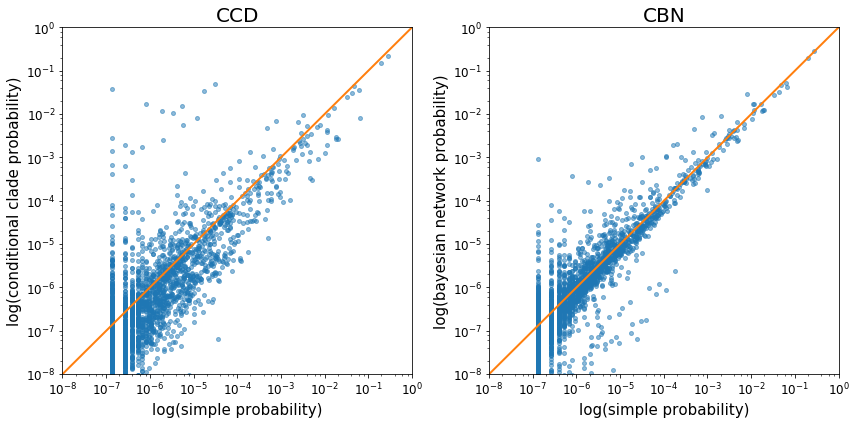

In [79]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(tree_wts_total, ccd_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-8,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax1.set_title('CCD', fontsize=20)
ax1.set_xlabel('log(simple probability)',fontsize=15)
ax1.set_ylabel('log(conditional clade probability)',fontsize=15)
ax1.tick_params(labelsize=12)
# ax.axis('equal')

ax2.plot(tree_wts_total, bn_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-8,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax2.set_title('CBN', fontsize=20)
ax2.set_xlabel('log(simple probability)',fontsize=15)
ax2.set_ylabel('log(bayesian network probability)',fontsize=15)
ax2.tick_params(labelsize=12)

plt.tight_layout()

# plt.savefig('figs/cbn-vs-ccd-DS1-rep1.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

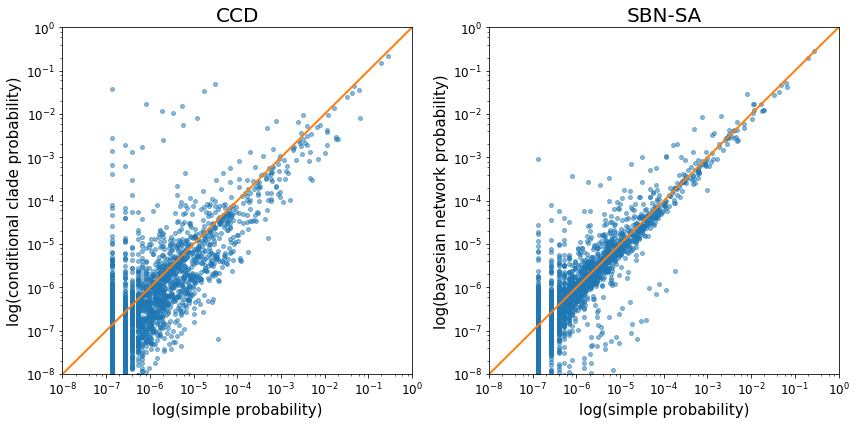

In [80]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12,6))
ax1.plot(tree_wts_total, ccd_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-8,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax1.set_title('CCD', fontsize=20)
ax1.set_xlabel('log(simple probability)',fontsize=15)
ax1.set_ylabel('log(conditional clade probability)',fontsize=15)
ax1.tick_params(labelsize=12)
# ax.axis('equal')

ax2.plot(tree_wts_total, bn_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-8,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax2.set_title('SBN-SA', fontsize=20)
ax2.set_xlabel('log(simple probability)',fontsize=15)
ax2.set_ylabel('log(bayesian network probability)',fontsize=15)
ax2.tick_params(labelsize=12)

plt.tight_layout()

# plt.savefig('figs/cbn-vs-ccd-DS1-rep1.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

In [28]:
logp = model.bn_em_prob(tree_dict_total, tree_names_total, tree_wts_total, maxiter=100, abstol=1e-05, monitor=True, MAP=False)

Iter 1: current per tree log-likelihood -2.954282
Iter 2: current per tree log-likelihood -2.950041
Iter 3: current per tree log-likelihood -2.949119
Iter 4: current per tree log-likelihood -2.948953
Iter 5: current per tree log-likelihood -2.948856
Iter 6: current per tree log-likelihood -2.948778
Iter 7: current per tree log-likelihood -2.948709
Iter 8: current per tree log-likelihood -2.948643
Iter 9: current per tree log-likelihood -2.948577
Iter 10: current per tree log-likelihood -2.948517
Iter 11: current per tree log-likelihood -2.948470
Iter 12: current per tree log-likelihood -2.948433
Iter 13: current per tree log-likelihood -2.948401
Iter 14: current per tree log-likelihood -2.948369
Iter 15: current per tree log-likelihood -2.948329
Iter 16: current per tree log-likelihood -2.948275
Iter 17: current per tree log-likelihood -2.948194
Iter 18: current per tree log-likelihood -2.948071
Iter 19: current per tree log-likelihood -2.947880
Iter 20: current per tree log-likelihood

In [26]:
logp = model.bn_em_prob(tree_dict, tree_names, tree_wts, maxiter=100, abstol=1e-05, monitor=True, MAP=False)

Iter 1: current per tree log-likelihood -2.935358
Iter 2: current per tree log-likelihood -2.931213
Iter 3: current per tree log-likelihood -2.930367
Iter 4: current per tree log-likelihood -2.930211
Iter 5: current per tree log-likelihood -2.930116
Iter 6: current per tree log-likelihood -2.930039
Iter 7: current per tree log-likelihood -2.929967
Iter 8: current per tree log-likelihood -2.929899
Iter 9: current per tree log-likelihood -2.929841
Iter 10: current per tree log-likelihood -2.929797
Iter 11: current per tree log-likelihood -2.929761
Iter 12: current per tree log-likelihood -2.929728
Iter 13: current per tree log-likelihood -2.929696
Iter 14: current per tree log-likelihood -2.929662
Iter 15: current per tree log-likelihood -2.929622
Iter 16: current per tree log-likelihood -2.929568
Iter 17: current per tree log-likelihood -2.929490
Iter 18: current per tree log-likelihood -2.929372
Iter 19: current per tree log-likelihood -2.929193
Iter 20: current per tree log-likelihood

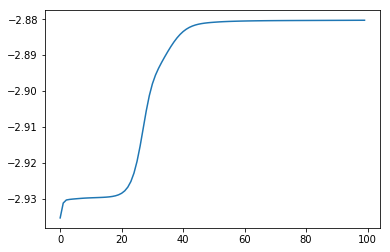

In [30]:
plt.plot(logp)
plt.show()

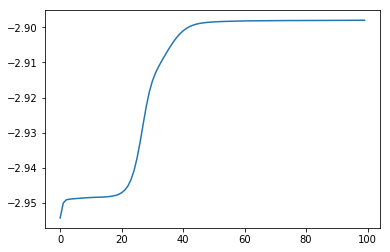

In [82]:
plt.plot(logp)
plt.show()

In [29]:
bn_em_est_prob = [model.bn_estimate(tree_dict_total[tree_name]) for tree_name in tree_names_total]

In [36]:
sum(bn_em_est_prob), max(bn_em_est_prob)

(0.99874230138556697, 0.27967062104978452)

In [85]:
sum(bn_em_est_prob), max(bn_em_est_prob)

(0.99949021865191612, 0.27660066113557019)

In [33]:
kl_div_mean = np.mean(kl_div_mat, axis=0)
kl_div_std = np.std(kl_div_mat, axis=0)
# kl_div_mean = kl_div_mean[1:]
# kl_div_std = kl_div_std[1:]

In [214]:
kl_div_mean = np.mean(kl_div_mat_merg, axis=0)
kl_div_std = np.std(kl_div_mat_merg, axis=0)

In [172]:
kl_div_mean

array([[ 0.7550389 ,  0.17739828,  0.17693583,  0.15775666,  0.1447686 ],
       [ 0.71145691,  0.13980951,  0.10613783,  0.10862155,  0.10124568],
       [ 0.6600345 ,  0.10562368,  0.05894317,  0.0666065 ,  0.06257933],
       [ 0.63813171,  0.09071294,  0.04050057,  0.04597726,  0.04403295],
       [ 0.61884985,  0.07871583,  0.02572267,  0.02323925,  0.02208401],
       [ 0.60799202,  0.07205473,  0.01770611,  0.01703985,  0.01637762],
       [ 0.6036772 ,  0.06908884,  0.01393435,  0.01358845,  0.01327526]])

In [34]:
kl_div_mean

array([[ 0.7550389 ,  0.17739828,  0.17693583,  0.13648644,  0.13909946,
         0.32753947],
       [ 0.71145691,  0.13980951,  0.10613782,  0.09194406,  0.09304879,
         0.21525833],
       [ 0.6600345 ,  0.10562368,  0.05894317,  0.05373837,  0.05405288,
         0.1279305 ],
       [ 0.63813171,  0.09071294,  0.04050057,  0.03627802,  0.03662631,
         0.07954375],
       [ 0.61884985,  0.07871583,  0.02572955,  0.02358631,  0.02378481,
         0.04569527],
       [ 0.60799202,  0.07205473,  0.0177061 ,  0.01648142,  0.01658734,
         0.02609571],
       [ 0.6036772 ,  0.06908884,  0.01393435,  0.01333929,  0.01341646,
         0.01474909]])

In [215]:
kl_div_mean

array([[ 0.7550389 ,  0.17739828,  0.17693583,  0.13648644,  0.13909946,
         0.32753947],
       [ 0.71145691,  0.13980951,  0.10613782,  0.09194406,  0.09304879,
         0.21525833],
       [ 0.6600345 ,  0.10562368,  0.05894317,  0.05373837,  0.05405288,
         0.1279305 ],
       [ 0.63813171,  0.09071294,  0.04050057,  0.03627802,  0.03662631,
         0.07954375],
       [ 0.61884985,  0.07871583,  0.02572955,  0.02358631,  0.02378481,
         0.04569527],
       [ 0.60799202,  0.07205473,  0.0177061 ,  0.01648142,  0.01658734,
         0.02609571],
       [ 0.6036772 ,  0.06908884,  0.01393435,  0.01333929,  0.01341646,
         0.01474909]])

In [32]:
kl_div_mat = np.load('../results/DS1/kl-div-mat-freq.npy')

In [35]:
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 'gray'] 

In [36]:
K_v = [10000, 20000, 40000, 80000, 160000, 320000, 640000]
labels={0:'ccd',1:'sbn-sa',2:'sbn-em',3:'sbn-em-'+r'$\alpha$',4:'sbn-em-'+r'$\alpha_1$', 5:'srf'}
fmts={0:'-o',1:'-s',2:'-d',3:'-^',4:'-*',5:'--P'}
marksz={0:5,1:5,2:6,3:6,4:8,5:6}

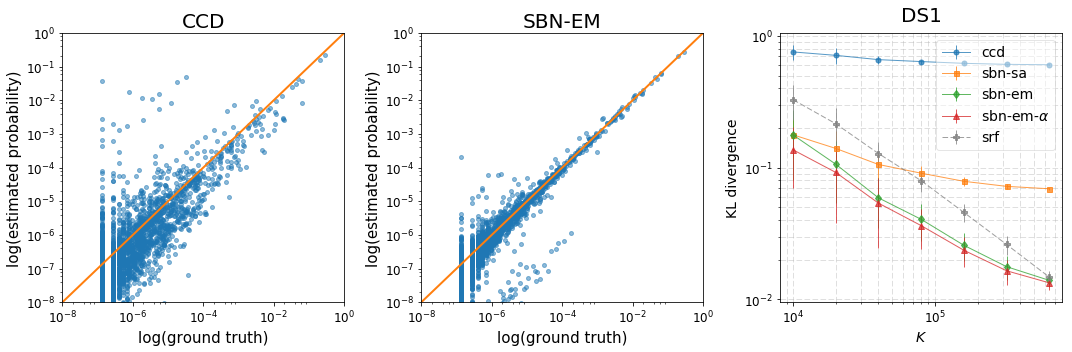

In [67]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.plot(tree_wts_total, ccd_est_prob, 'o', markersize=4, alpha=0.5)
ax1.set_xlim([1e-8,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax1.set_title('CCD', fontsize=20)
ax1.set_xlabel('log(ground truth)',fontsize=15)
ax1.set_ylabel('log(estimated probability)',fontsize=15)
ax1.tick_params(labelsize=12)
# ax.axis('equal')

# ax2.plot(tree_wts_total, bn_est_prob, 'o', markersize=4, alpha=0.5)
# ax2.set_xlim([1e-8,1])
# ax2.set_ylim(ax2.get_xlim())
# ax2.loglog([1e-8,1],[1e-8,1],linewidth=2)
# ax2.set_title('SBN-SA', fontsize=20)
# ax2.set_xlabel('log(simple probability)',fontsize=15)
# ax2.set_ylabel('log(bayesian network probability)',fontsize=15)
# ax2.tick_params(labelsize=12)

ax2.plot(tree_wts_total, bn_em_est_prob, 'o', markersize=4, alpha=0.5)
ax2.set_xlim([1e-8,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-8,1],[1e-8,1],linewidth=2)
ax2.set_title('SBN-EM', fontsize=20)
ax2.set_xlabel('log(ground truth)',fontsize=15)
ax2.set_ylabel('log(estimated probability)',fontsize=15)
ax2.tick_params(labelsize=12)


ax3.set_xscale('log')
ax3.set_yscale('log')
for i in [0,1,2,3,5]:
    ax3.errorbar(K_v, kl_div_mean[:,i], yerr=kl_div_std[:,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)
    
leg = ax3.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax3.grid(which='both', linestyle='--', alpha=0.5)
ax3.tick_params(labelsize=12)
ax3.set_xlabel(r'$K$', fontsize=14)
ax3.set_ylabel('KL divergence', fontsize=14)
ax3.set_title('DS1', y=1.02, fontsize=20)

plt.tight_layout()

plt.savefig('figs/sbn-vs-ccd-DS1-kl-freq-grey-new-label.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

In [49]:
peak1_idx = [idx for idx, peak in idx2peaks if peak==1]

In [52]:
peak2_idx

[3, 7, 8, 9, 13, 14, 16, 18, 20, 21, 23, 22, 31, 36, 37, 40, 41, 42]

In [50]:
peak2_idx = [idx for idx, peak in idx2peaks if peak==2]

In [44]:
peaks = [1,1,2,1,1,1,1,2,2,2,1,1,2,1,2,1,2,2,1,2,1,2,2,2,1,1,1,1,1,1,2,1,1,1,1,1,2,2,1,1,2,2,2]

In [47]:
idx2peaks = [(idx, peaks[rank]) for rank, (wts, idx) in enumerate(sorted([(wts,idx) for idx, wts in enumerate(tree_wts_total)], key=lambda x:x[0], reverse=True)[:43])]

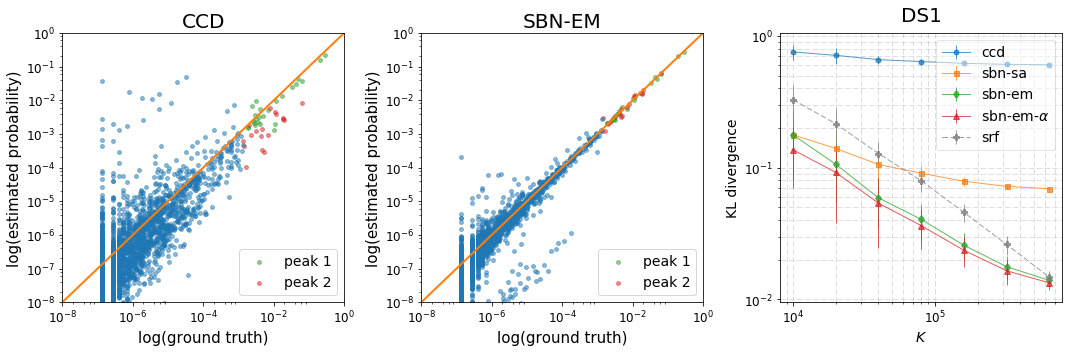

In [63]:
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
ax1.scatter(np.array(tree_wts_total)[peak1_idx], np.array(ccd_est_prob)[peak1_idx], s=15, alpha=0.5, c=colors[2], label='peak 1')
ax1.scatter(np.array(tree_wts_total)[peak2_idx], np.array(ccd_est_prob)[peak2_idx], s=15, alpha=0.5, c=colors[3], label='peak 2')
ax1.scatter(tree_wts_total[43:], ccd_est_prob[43:], s=15, alpha=0.5, c=colors[0])
ax1.set_xlim([1e-8,1])
ax1.set_ylim(ax1.get_xlim())
ax1.loglog([1e-8,1],[1e-8,1],linewidth=2, color=colors[1])
ax1.set_title('CCD', fontsize=20)
ax1.set_xlabel('log(ground truth)',fontsize=15)
ax1.set_ylabel('log(estimated probability)',fontsize=15)
ax1.tick_params(labelsize=12)
ax1.legend(loc='best', fontsize=14)
# ax.axis('equal')

# ax2.plot(tree_wts_total, bn_est_prob, 'o', markersize=4, alpha=0.5)
# ax2.set_xlim([1e-8,1])
# ax2.set_ylim(ax2.get_xlim())
# ax2.loglog([1e-8,1],[1e-8,1],linewidth=2)
# ax2.set_title('SBN-SA', fontsize=20)
# ax2.set_xlabel('log(simple probability)',fontsize=15)
# ax2.set_ylabel('log(bayesian network probability)',fontsize=15)
# ax2.tick_params(labelsize=12)

ax2.scatter(np.array(tree_wts_total)[peak1_idx], np.array(bn_em_est_prob)[peak1_idx], s=15, alpha=0.5, c=colors[2], label='peak 1')
ax2.scatter(np.array(tree_wts_total)[peak2_idx], np.array(bn_em_est_prob)[peak2_idx], s=15, alpha=0.5, c=colors[3], label='peak 2')
ax2.scatter(tree_wts_total[43:], bn_em_est_prob[43:], s=15, alpha=0.5, c=colors[0])

#ax2.scatter(tree_wts_total, bn_em_est_prob, s=15, alpha=0.5, c=colors[0])
ax2.set_xlim([1e-8,1])
ax2.set_ylim(ax2.get_xlim())
ax2.loglog([1e-8,1],[1e-8,1],linewidth=2, color=colors[1])
ax2.set_title('SBN-EM', fontsize=20)
ax2.set_xlabel('log(ground truth)',fontsize=15)
ax2.set_ylabel('log(estimated probability)',fontsize=15)
ax2.tick_params(labelsize=12)
ax2.legend(loc=4, fontsize=14)

ax3.set_xscale('log')
ax3.set_yscale('log')
for i in [0,1,2,3,5]:
    ax3.errorbar(K_v, kl_div_mean[:,i], yerr=kl_div_std[:,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)
    
leg = ax3.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax3.grid(which='both', linestyle='--', alpha=0.5)
ax3.tick_params(labelsize=12)
ax3.set_xlabel(r'$K$', fontsize=14)
ax3.set_ylabel('KL divergence', fontsize=14)
ax3.set_title('DS1', y=1.02, fontsize=20)

plt.tight_layout()

plt.savefig('figs/sbn-vs-ccd-DS1-kl-freq-grey-new-label.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()

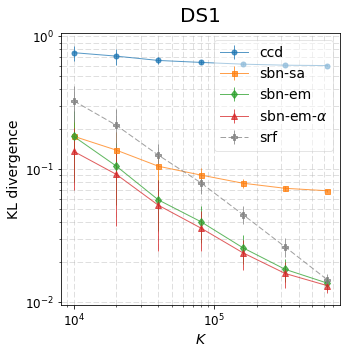

In [262]:
fig, ax3 = plt.subplots(figsize=(5,5))
ax3.set_xscale('log')
ax3.set_yscale('log')
for i in [0,1,2,3,5]:
    ax3.errorbar(K_v, kl_div_mean[:,i], yerr=kl_div_std[:,i], c=colors[i], label=labels[i], fmt=fmts[i],markersize=marksz[i], alpha=0.75, linewidth=1)
    
leg = ax3.legend(loc='best',fontsize=14)
leg.get_frame().set_alpha(0.5)
ax3.grid(which='both', linestyle='--', alpha=0.5)
ax3.tick_params(labelsize=12)
ax3.set_xlabel(r'$K$', fontsize=14)
ax3.set_ylabel('KL divergence', fontsize=14)
ax3.set_title('DS1', y=1.02, fontsize=20)

plt.savefig('../figs/sbn-vs-ccd-DS1-kl-freq.pdf', transparent=True, dpi=1200, bbox_inches='tight')

plt.show()